# Predicting Cancer Survival Months Based on Diagnosis Data

### Import Libraries

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import auc


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold



import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Embedding, BatchNormalization, Dense, Dropout, Flatten, Concatenate, concatenate, SpatialDropout1D
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 500

%matplotlib inline

In [2]:
# Read the dataset 
df = pd.read_csv('case_reduced_label_revised.csv')
df.head()

,Age recode with <1 year olds,Sex,Year of diagnosis,"Race recode (W, B, AI, API)","Origin recode NHIA (Hispanic, Non-Hisp)",Site recode ICD-O-3/WHO 2008,Behavior code ICD-O-3,Grade (thru 2017),Grade Clinical (2018+),Grade Pathological (2018+),Laterality,Diagnostic Confirmation,SEER Combined Summary Stage 2000 (2004-2017),"Derived AJCC Stage Group, 6th ed (2004-2015)","Derived AJCC T, 6th ed (2004-2015)","Derived AJCC N, 6th ed (2004-2015)","Derived AJCC M, 6th ed (2004-2015)",Reason no cancer-directed surgery,RX Summ--Scope Reg LN Sur (2003+),RX Summ--Surg Oth Reg/Dis (2003+),CS tumor size (2004-2015),CS extension (2004-2015),COD to site recode,SEER cause-specific death classification,Survival months,Survival months flag,COD to site rec KM,Vital status recode (study cutoff used),Total number of in situ/malignant tumors for patient,Total number of benign/borderline tumors for patient,First malignant primary indicator,Age recode with single ages and 85+,Race/ethnicity,Patient ID,Type of Reporting Source,Median household income inflation adj to 2019,Rural-Urban Continuum Code,Regional nodes examined (1988+),Regional nodes positive (1988+)
0,40-44 years,Male,2002,White,Non-Spanish-Hispanic-Latino,Testis,Malignant,Unknown,Blank(s),Blank(s),Left - origin of primary,Positive histology,Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Surgery performed,Blank(s),Blank(s),Blank(s),Blank(s),Alive,Alive or dead of other cause,0196,Complete dates are available and there are mor...,Alive,Alive,2,0,No,44 years,White,17,Hospital inpatient/outpatient or clinic,"$75,000+",Counties in metropolitan areas ge 1 million pop,0,98
1,65-69 years,Male,2000,White,Non-Spanish-Hispanic-Latino,Rectum,Malignant,Well differentiated; Grade I,Blank(s),Blank(s),Not a paired site,Positive histology,Blank(s),Blank(s),Blank(s),Blank(s),Blank(s),Surgery performed,Blank(s),Blank(s),Blank(s),Blank(s),Rectum and Rectosigmoid Junction,Dead (attributable to this cancer dx),0049,Complete dates are available and there are mor...,Rectum and Rectosigmoid Junction,Dead,2,0,No,69 years,White,20,Hospital inpatient/outpatient or clinic,"$75,000+",Counties in metropolitan areas ge 1 million pop,10,0
2,35-39 years,Female,2008,White,Spanish-Hispanic-Latino,Rectosigmoid Junction,Malignant,Moderately differentiated; Grade II,Blank(s),Blank(s),Not a paired site,Positive histology,Distant site(s)/node(s) involved,IV,T3,N1,M1,Surgery performed,4 or more regional lymph nodes removed,None; diagnosed at autopsy,035,400,Alive,Alive or dead of other cause,0131,Complete dates are available and there are mor...,Alive,Alive,2,0,No,39 years,White,25,Hospital inpatient/outpatient or clinic,"$75,000+",Counties in metropolitan areas ge 1 million pop,8,1
3,60-64 years,Female,2008,White,Non-Spanish-Hispanic-Latino,"Trachea, Mediastinum and Other Respiratory Organs",Malignant,Well differentiated; Grade I,Blank(s),Blank(s),Not a paired site,Positive histology,Localized only,IB,T2b,N0,M0,Surgery performed,None,None; diagnosed at autopsy,090,100,"Trachea, Mediastinum and Other Respiratory Organs",Dead (attributable to this cancer dx),0000,Complete dates are available and there are mor...,"Trachea, Mediastinum and Other Respiratory Organs",Dead,2,0,No,63 years,White,41,Hospital inpatient/outpatient or clinic,"$75,000+",Counties in metropolitan areas ge 1 million pop,0,98
4,85+ years,Male,2008,White,Non-Spanish-Hispanic-Latino,Melanoma of the Skin,Malignant,Unknown,Blank(s),Blank(s),Not a paired site,Positive histology,Localized only,IB,T2a,N0,M0,Surgery performed,None,None; diagnosed at autopsy,999,400,Other Cause of Death,Alive or dead of other cause,0026,Complete dates are available and there are mor...,Other Cause of Death,Dead,2,0,No,85+ years,White,51,Hospital inpatient/outpatient or clinic,"$75,000+",Counties in metropolitan areas ge 1 million pop,0,98


Have a look at the columns of the dataset

In [3]:
df.columns

Index(['Age recode with <1 year olds', 'Sex', 'Year of diagnosis',
       'Race recode (W, B, AI, API)',
       'Origin recode NHIA (Hispanic, Non-Hisp)',
       'Site recode ICD-O-3/WHO 2008', 'Behavior code ICD-O-3',
       'Grade (thru 2017)', 'Grade Clinical (2018+)',
       'Grade Pathological (2018+)', 'Laterality', 'Diagnostic Confirmation',
       'SEER Combined Summary Stage 2000 (2004-2017)',
       'Derived AJCC Stage Group, 6th ed (2004-2015)',
       'Derived AJCC T, 6th ed (2004-2015)',
       'Derived AJCC N, 6th ed (2004-2015)',
       'Derived AJCC M, 6th ed (2004-2015)',
       'Reason no cancer-directed surgery',
       'RX Summ--Scope Reg LN Sur (2003+)',
       'RX Summ--Surg Oth Reg/Dis (2003+)', 'CS tumor size (2004-2015)',
       'CS extension (2004-2015)', 'COD to site recode',
       'SEER cause-specific death classification', 'Survival months',
       'Survival months flag', 'COD to site rec KM',
       'Vital status recode (study cutoff used)',
       'Total

Some of the diagnosis data are available for patients with diagnosis year between 2004-2017. Then, it makes sense to filter patients with diagnosis year earlier than 2004 or later than 2017. Also, it seems there are a number of columns which are irrelevant such as `'Type of Reporting Source','COD to site recode'`. 


In [4]:
# filter out patients with diagnosis year 
df = df[df['Year of diagnosis']>=2004]
df = df[df['Year of diagnosis']<=2017]

drop_columns = ['Age recode with <1 year olds', 
               'Grade Clinical (2018+)',
               'Grade Pathological (2018+)',
               'COD to site rec KM',
               'Race/ethnicity',
               'Patient ID',
               'Type of Reporting Source',
               'COD to site recode',
               ]
df.drop(columns=drop_columns,inplace=True)

In [9]:
# for some reasons Keras does not like strange characters such as +, / in the input names. For this reason, we have to change
# column names 
df.columns = [col_name.replace(' ', '_').replace('+','').replace(',','')\
                .replace('(', '').replace(')','').replace('/', '_').replace('-', '_') for col_name in df.columns]
df.columns

Index(['Sex', 'Year_of_diagnosis', 'Race_recode_W_B_AI_API',
       'Origin_recode_NHIA_Hispanic_Non_Hisp', 'Site_recode_ICD_O_3_WHO_2008',
       'Behavior_code_ICD_O_3', 'Grade_thru_2017', 'Laterality',
       'Diagnostic_Confirmation', 'SEER_Combined_Summary_Stage_2000_2004_2017',
       'Derived_AJCC_Stage_Group_6th_ed_2004_2015',
       'Derived_AJCC_T_6th_ed_2004_2015', 'Derived_AJCC_N_6th_ed_2004_2015',
       'Derived_AJCC_M_6th_ed_2004_2015', 'Reason_no_cancer_directed_surgery',
       'RX_Summ__Scope_Reg_LN_Sur_2003', 'RX_Summ__Surg_Oth_Reg_Dis_2003',
       'CS_tumor_size_2004_2015', 'CS_extension_2004_2015',
       'SEER_cause_specific_death_classification', 'Survival_months',
       'Survival_months_flag', 'Vital_status_recode_study_cutoff_used',
       'Total_number_of_in_situ_malignant_tumors_for_patient',
       'Total_number_of_benign_borderline_tumors_for_patient',
       'First_malignant_primary_indicator',
       'Age_recode_with_single_ages_and_85',
       'Median_

In [10]:
# Drop the duplicate rows
df.drop_duplicates(inplace=True)

## Explanatory Data Analysis

We first have a close look at the data to have a better understanding of the dataset and how to approach the problem. 

In [11]:
print(f'The number of patients in the dataset is {df.shape[0]}')

The number of patients in the dataset is 6531897


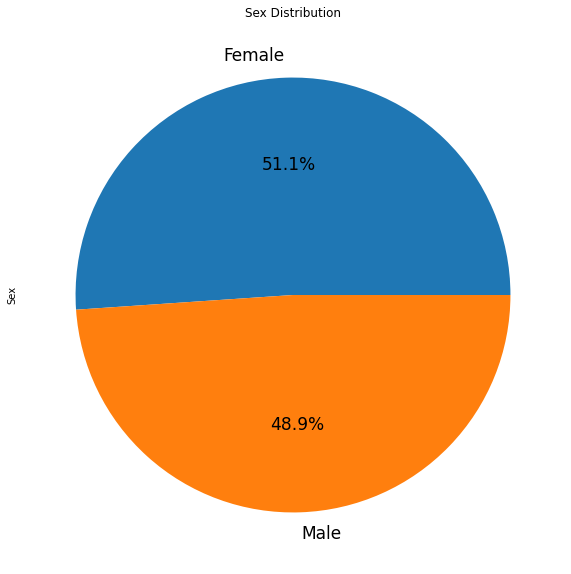

In [12]:
df['Sex'].value_counts().plot(kind='pie',
                              figsize=(15,10),
                              autopct='%1.1f%%',
                              fontsize=17,
                              title='Sex Distribution',
                              dpi=400);
plt.gcf().set_dpi(300)

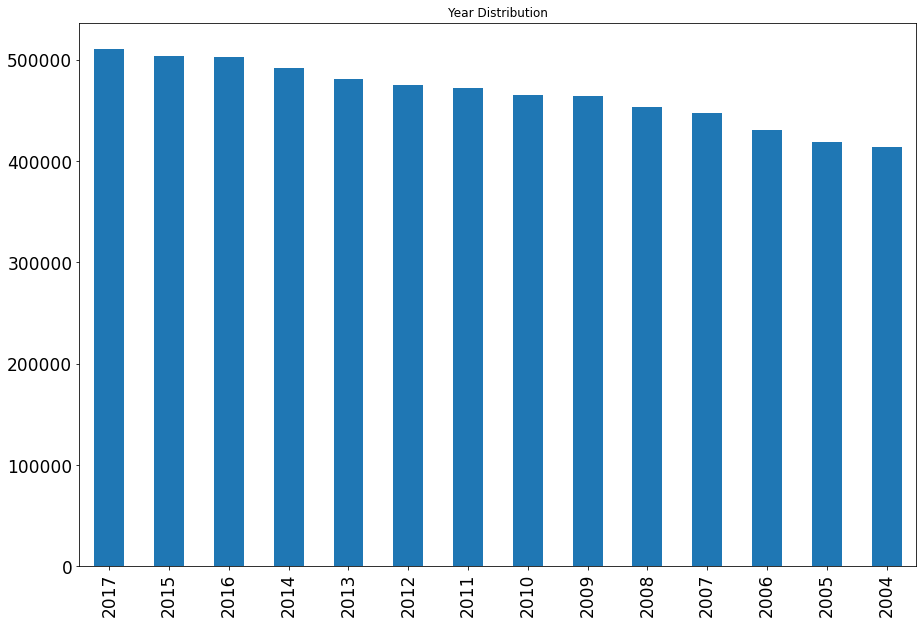

In [13]:
df['Year_of_diagnosis'].value_counts().plot(kind='bar',
                                            figsize=(15,10),
                                            fontsize=17,
                                            title='Year Distribution');
plt.gcf().set_dpi(300)


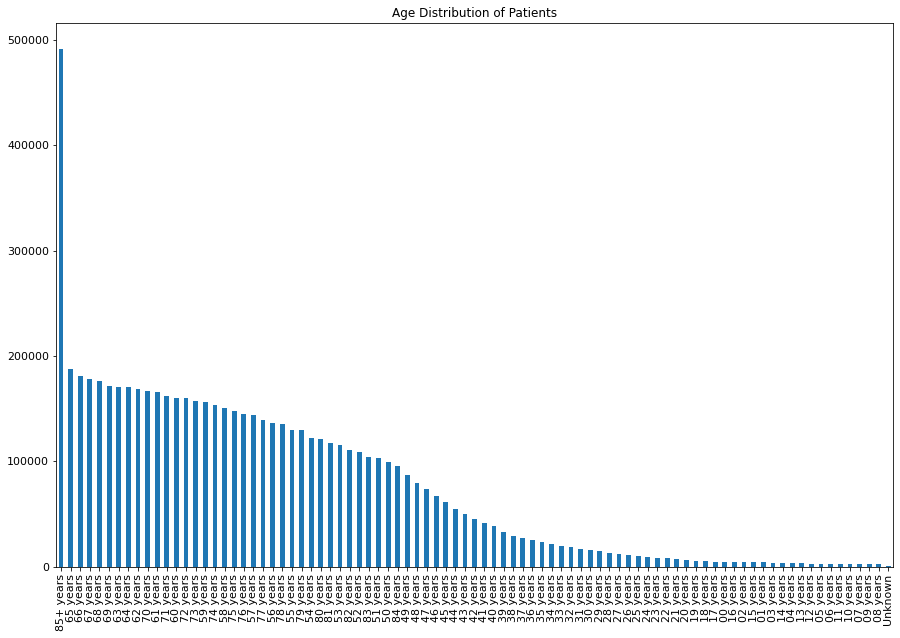

In [14]:
df['Age_recode_with_single_ages_and_85'].value_counts().plot(kind='bar',figsize=(15,10), 
                                                             title='Age Distribution of Patients',
                                                             fontsize=11,);
plt.gcf().set_dpi(300)

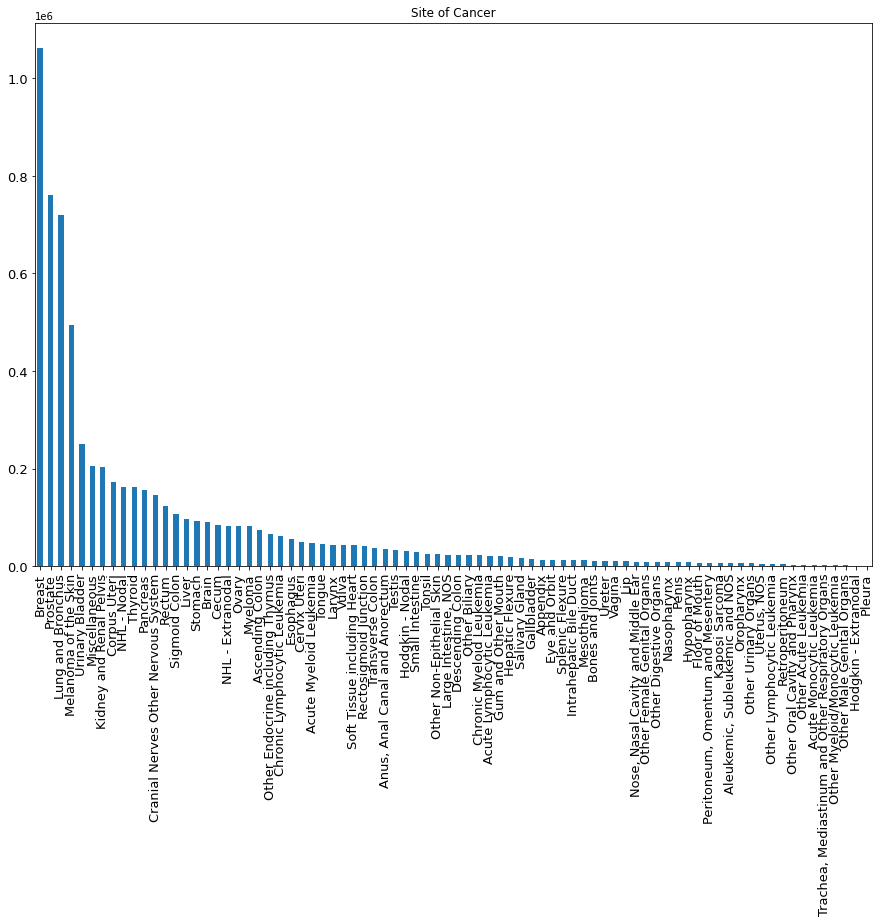

In [15]:
df['Site_recode_ICD_O_3_WHO_2008'].value_counts().plot(kind='bar',figsize=(15,10), 
                                                      title='Site of Cancer',
                                                      fontsize=13,);
plt.gcf().set_dpi(300)

In [16]:
df['Survival_months']

2          0131
3          0000
4          0026
7          0142
8          0094
           ... 
8666494    0107
8666517    0094
8666535    0046
8666650    0051
8666661    0034
Name: Survival_months, Length: 6531897, dtype: object

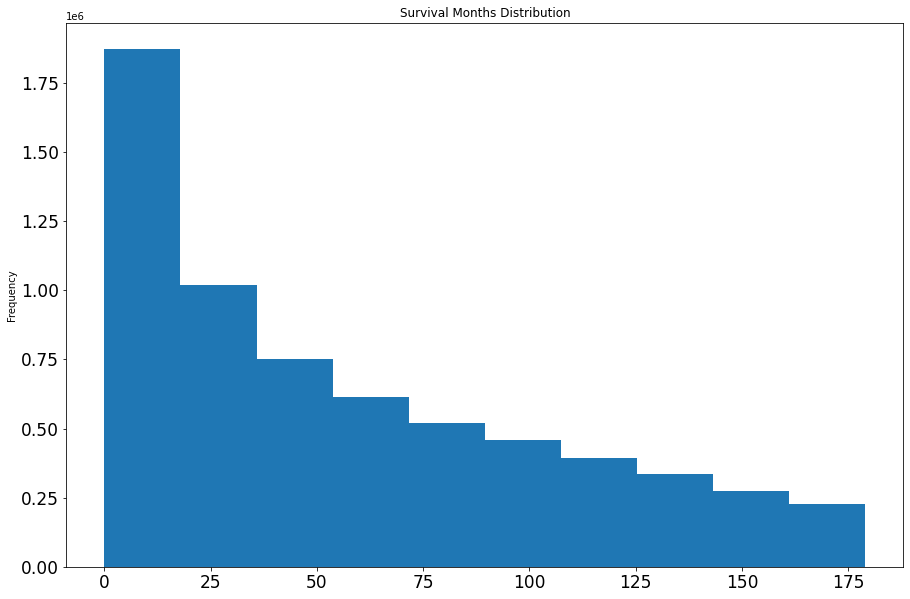

In [17]:
df['Survival_months'] = pd.to_numeric(df['Survival_months'],errors='coerce') #change survival months to a numeric type
df['Survival_months'].plot(kind='hist',figsize=(15,10), 
                                    title='Survival Months Distribution',
                                    fontsize=17,);
plt.gcf().set_dpi(300)

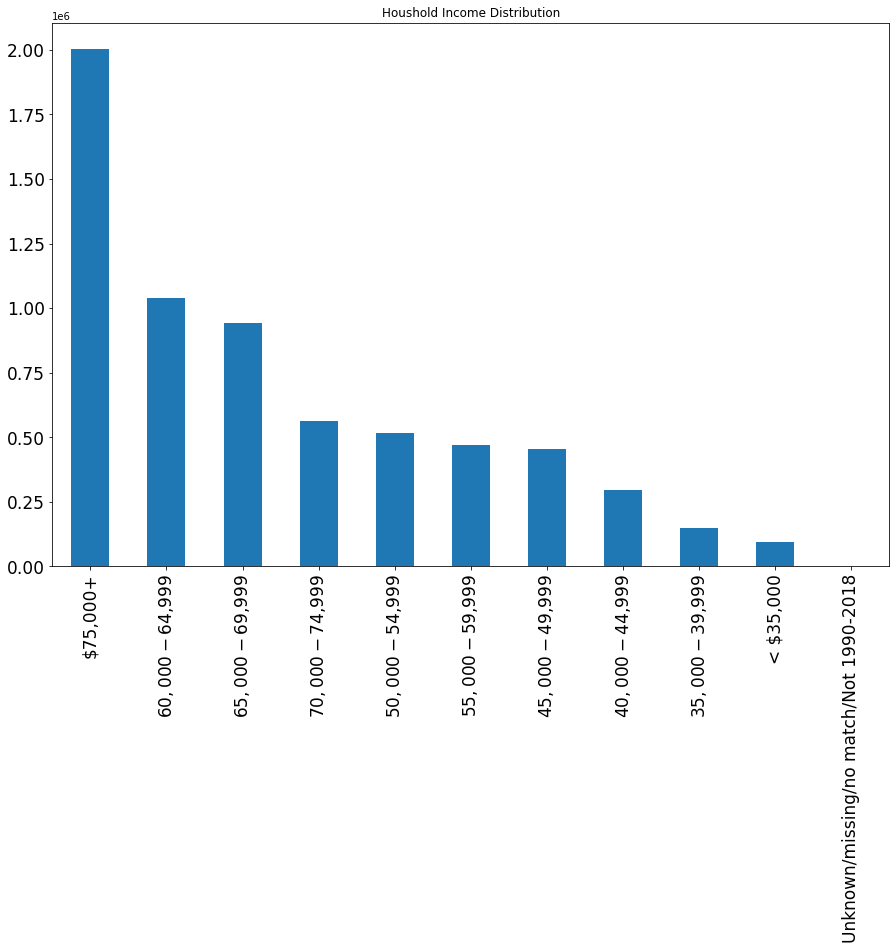

In [18]:
df['Median_household_income_inflation_adj_to_2019'].value_counts().plot(kind='bar',figsize=(15,10), 
                                                                        title='Houshold Income Distribution',
                                                                        fontsize=17,);
plt.gcf().set_dpi(300)

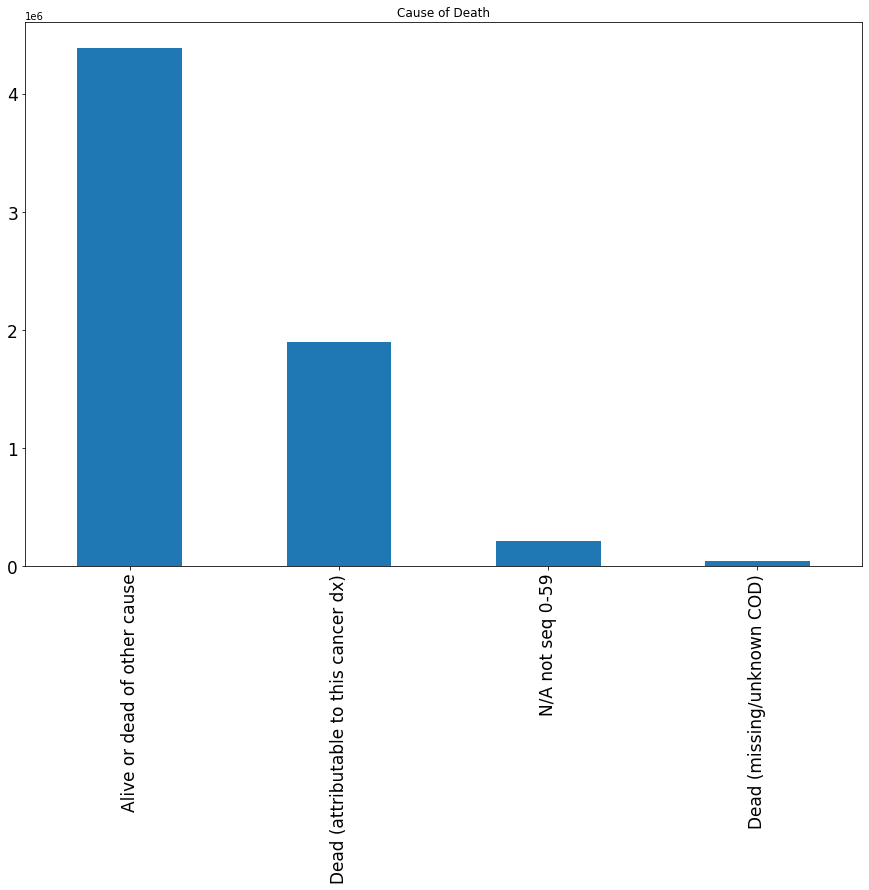

In [19]:
df['SEER_cause_specific_death_classification'].value_counts().plot(kind='bar',figsize=(15,10), 
                                                                        title='Cause of Death',
                                                                        fontsize=17,);
plt.gcf().set_dpi(300)

## Machine Learning

Now it comes to the learning part. We are going to find answers to two questions: 
1. Is it possible to predict whether or not the patient eventually would pass away due to complications associated with his/her cancer?
2. For patients who eventually pass away due to cancer, can we predict the time period during which the patient is expected to survive?

The first problem is a binary classification problem while the second one is a regression problem to predict the number of months the patient is expected to survive. 













## Predict Chance of Survival

In this section, we try to answer the first question that is to predict whether or not the cancer would be the main cause of death in each patient. Some columns are of object type by nature; examples include `Sex, Race, Laterality`. But, some columns can be interpreted as a mixed type. For example, `Age recode with single ages and 85+` column contains the information regarding the age of patient. However, if patients are older than 85, a single category is assigned to them. In other words, a patients with 85 years is assigned to the same category as the patient of age 92. There are three [ways to encode categorical variables](https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/). The most common approach is to use One Hot Encoding also known as dummy encoding. However, as we will see this approach is not always the best option because first of all it is computationally complex (the generated matrices are HUGE). Also, when using one hot encoding the encoded features are all orthogonal to each other which is far from being accurate.

Let us first try one hot encoding to see its performance.  



<!-- For this reason, we tried two different approaches to solve the problem. 
1. Try to change columns to numeric type as much as possible. For example, change the Age column to numeric value and ignore the fact the patients older than 85 are assigned the same age. 
2. Do not change data types and work directly with categorical data.

The two approaches are explored and compared in the following. Let's first change the columns as much as possible.  -->

### One hot encoding

Most columns are of 'object' type. Then, some data types need to be modified. 

In [20]:
df.dtypes

Sex                                                      object
Year_of_diagnosis                                         int64
Race_recode_W_B_AI_API                                   object
Origin_recode_NHIA_Hispanic_Non_Hisp                     object
Site_recode_ICD_O_3_WHO_2008                             object
Behavior_code_ICD_O_3                                    object
Grade_thru_2017                                          object
Laterality                                               object
Diagnostic_Confirmation                                  object
SEER_Combined_Summary_Stage_2000_2004_2017               object
Derived_AJCC_Stage_Group_6th_ed_2004_2015                object
Derived_AJCC_T_6th_ed_2004_2015                          object
Derived_AJCC_N_6th_ed_2004_2015                          object
Derived_AJCC_M_6th_ed_2004_2015                          object
Reason_no_cancer_directed_surgery                        object
RX_Summ__Scope_Reg_LN_Sur_2003          

#### Change data types to numeric

First of all, it seems that nan is partly represented with the string 'Blank(s)' in the entire dataset. Let's replace 'Blanks(s)' with nan. 

In [21]:
df.replace('Blank(s)',np.nan,inplace=True)
for col in df.columns:
    if df[col].isna().sum() > 0:
        print(f'There are {df[col].isna().sum()} NaNs in column {col} corresponding to {df[col].isna().mean() * 100:.2f} percent of cases')

There are 1777327 NaNs in column Derived_AJCC_Stage_Group_6th_ed_2004_2015 corresponding to 27.21 percent of cases
There are 2002536 NaNs in column Derived_AJCC_T_6th_ed_2004_2015 corresponding to 30.66 percent of cases
There are 2003008 NaNs in column Derived_AJCC_N_6th_ed_2004_2015 corresponding to 30.67 percent of cases
There are 2002536 NaNs in column Derived_AJCC_M_6th_ed_2004_2015 corresponding to 30.66 percent of cases
There are 1014123 NaNs in column CS_tumor_size_2004_2015 corresponding to 15.53 percent of cases
There are 1014123 NaNs in column CS_extension_2004_2015 corresponding to 15.53 percent of cases
There are 58129 NaNs in column Survival_months corresponding to 0.89 percent of cases


In [22]:
df['Survival_months'] = pd.to_numeric(df['Survival_months'],errors='coerce') #change survival months to a numeric type

#####  Regional nodes examined (1988+)

This column follows the following convention:

![title](imgs/regional_nodes_examined.png)
The code 99 is almost the same as nan. As of the codes 95-98 we remove them all as they are actually associated with category and do not represent numbers. 

In [23]:
for i in [95,96,97,98]:
    df = df[df['Regional_nodes_examined_1988'] != i]
df['Regional_nodes_examined_1988'].replace(99,np.nan, inplace=True)
(df['Regional_nodes_examined_1988'] >= 95).sum() # just to make sure

0

##### Regional nodes positive (1988+)

This column follows the following convention:
![title](imgs/Regional_nodes_positive.png)
The code 98, 99 are almost the same as nan. 

In [24]:
df['Regional_nodes_positive_1988'].replace(98,np.nan, inplace=True)
df['Regional_nodes_positive_1988'].replace(99,np.nan, inplace=True)
df['Regional_nodes_positive_1988'].replace(97,np.nan, inplace=True)
df = df[df['Regional_nodes_positive_1988'] != 95]
(df['Regional_nodes_positive_1988'] > 90).sum()

0

##### CS tumor size (2004-2015)

This column follows the following convention:
![title](imgs/CS_tumor_size.png)
 888, 999 and 996-998 should be replaced with nan.
 For values between 991 to 995, we replace them with a random number. For example, for 991, we replace it with a number between 0-10 and for 992, we replace it with a random number between 10-20. The rational behind this replacement is that when we say Tumor size is less than 5cm but not less than 4cm, it should be within 4-5cm.

In [25]:
df['CS_tumor_size_2004_2015'].replace("'",'', inplace=True)
df['CS_tumor_size_2004_2015'] = pd.to_numeric(df['CS_tumor_size_2004_2015'])
for i in [888,999,996,997,998, 991, 992, 993, 994, 995]:
    df['CS_tumor_size_2004_2015'].replace(i,np.nan, inplace=True)
maping = {991:1, 992:2, 993:3, 994:4, 995:5}
for key, value in maping.items():
    df.loc[df['CS_tumor_size_2004_2015'] == key,'CS_tumor_size_2004_2015'] =\
    np.random.uniform(low=(value-1)*10, high=value*10, size=len(df.loc[df['CS_tumor_size_2004_2015'] == key]))
df['CS_tumor_size_2004_2015'].replace(990,0, inplace=True)    
(df['CS_tumor_size_2004_2015'] >= 990).sum()

0

##### CS extension (2004-2015)

In [26]:
df['CS_extension_2004_2015'].replace("'",'', inplace=True)
df['CS_extension_2004_2015'] = pd.to_numeric(df['CS_extension_2004_2015'])
df['CS_extension_2004_2015'].replace(999,np.nan, inplace=True)
(df['CS_extension_2004_2015'] >= 990).sum()

0

##### The number of In situ/ malignant tumors

In [27]:
df['Total_number_of_in_situ_malignant_tumors_for_patient'] = \
            pd.to_numeric(df['Total_number_of_in_situ_malignant_tumors_for_patient'],errors='coerce')

df['Total_number_of_benign_borderline_tumors_for_patient'] = \
            pd.to_numeric(df['Total_number_of_benign_borderline_tumors_for_patient'],errors='coerce')
# df['Total number of benign/borderline tumors for patient'].fillna(0,inplace=True)

##### Age column

In [28]:
df['Age_recode_with_single_ages_and_85'] = df['Age_recode_with_single_ages_and_85'].str.replace('years','')
df['Age_recode_with_single_ages_and_85'] = df['Age_recode_with_single_ages_and_85'].str.replace('+','')
df['Age_recode_with_single_ages_and_85'] = pd.to_numeric(df['Age_recode_with_single_ages_and_85'],errors='coerce')

We first need to decide which columns to use to predict the survival months. If the number of selected columns is large, we face a memory issue since the associated matrices become very large. The list below shows the full list of columns which are likely to play a role in predicting the survival months. However, selecting all of them leads to a memory error `Unable to allocate 29.9 GiB for an array with shape (479, 8374657) and data type float64`. Hence,we should limit our attention to just a few columns (Don't worry we will fix this issue further down in the notebook by using an embedding layer in neural network). This is the reason why some of the rows are commented. 


In [33]:
relevant_cols = [
                 'Sex',
                 'Site_recode_ICD_O_3_WHO_2008',
                 'Behavior_code_ICD_O_3',
#                  'Laterality', 
#                  'Reason_no_cancer_directed_surgery', 
                 'SEER_Combined_Summary_Stage_2000_2004_2017',
                 'Regional_nodes_examined_1988',
                 'Regional_nodes_positive_1988', 
                 'CS_tumor_size_2004_2015',
                 'CS_extension_2004_2015', 
                 'Total_number_of_in_situ_malignant_tumors_for_patient',
                 'Total_number_of_benign_borderline_tumors_for_patient',
#                  'First_malignant_primary_indicator',
                 'Age_recode_with_single_ages_and_85', 
                 'SEER_cause_specific_death_classification',
#                  'Median_household_income_inflation_adj_to_2019',
#                  'Rural_Urban_Continuum_Code',
#                  'Diagnostic_Confirmation',
                 'Survival_months',
                 'Derived_AJCC_Stage_Group_6th_ed_2004_2015',
#                  'Derived_AJCC_T_6th_ed_2004_2015',
#                  'Derived_AJCC_N_6th_ed_2004_2015',
#                  'Derived_AJCC_M_6th_ed_2004_2015',
                 'RX_Summ__Scope_Reg_LN_Sur_2003',
                 'RX_Summ__Surg_Oth_Reg_Dis_2003',
                 'Grade_thru_2017',
                ]

In [34]:
df[relevant_cols].dtypes

Sex                                                      object
Site_recode_ICD_O_3_WHO_2008                             object
Behavior_code_ICD_O_3                                    object
SEER_Combined_Summary_Stage_2000_2004_2017               object
Regional_nodes_examined_1988                            float64
Regional_nodes_positive_1988                            float64
CS_tumor_size_2004_2015                                 float64
CS_extension_2004_2015                                  float64
Total_number_of_in_situ_malignant_tumors_for_patient    float64
Total_number_of_benign_borderline_tumors_for_patient    float64
Age_recode_with_single_ages_and_85                      float64
SEER_cause_specific_death_classification                 object
Survival_months                                         float64
Derived_AJCC_Stage_Group_6th_ed_2004_2015                object
RX_Summ__Scope_Reg_LN_Sur_2003                           object
RX_Summ__Surg_Oth_Reg_Dis_2003          

The following function 

In [35]:
def clean_data_classification(df, columns_index):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no Survival months
    2. Create X as all the columns that are in columns_index
    3. Create y as the Survival months column
    4. For each numeric variable in X, fill the nan with the mean value of the column.
    5. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Drop rows with missing survival months
    df = df.dropna(subset=['SEER_cause_specific_death_classification'], axis=0)
    df = df[(df['SEER_cause_specific_death_classification'] != 'N/A not seq 0-59') & 
        (df['SEER_cause_specific_death_classification'] != 'Dead (missing/unknown COD)')]
    y = df['SEER_cause_specific_death_classification']
    y[y == 'Dead (attributable to this cancer dx)'] = 1
    y[y == 'Alive or dead of other cause'] = 0
    y = pd.to_numeric(y)
    
    # exclude columns which are not in columns_index
#     df = df[columns_index]
    df = df[columns_index].drop(columns=['Survival_months', 'SEER_cause_specific_death_classification'])
        
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, \
                                                             prefix_sep='_', dummy_na=False, drop_first=False)], axis=1)
    
    X = df
    return X, y

In [36]:
X, y = clean_data_classification(df, relevant_cols)
x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=0.3) # split the data set into test and train

As the first attempt, we try `LogisticRegression` from `xgboost` library. 

In [137]:
clf = LogisticRegression(verbose=1, solver='lbfgs', max_iter=300)
clf.fit(x_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          179     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97707D+06    |proj g|=  1.43454D+08

At iterate   50    f=  1.85269D+06    |proj g|=  4.91435D+05

At iterate  100    f=  1.74906D+06    |proj g|=  5.08202D+06

At iterate  150    f=  1.68099D+06    |proj g|=  3.68445D+05

At iterate  200    f=  1.67056D+06    |proj g|=  5.59521D+05

At iterate  250    f=  1.65391D+06    |proj g|=  5.47733D+05

At iterate  300    f=  1.64365D+06    |proj g|=  5.57408D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.1min finished


LogisticRegression(max_iter=300, verbose=1)

In [145]:
clf.score(x_test,y_test)

0.8317829411039285

In [37]:
model = Sequential()
model.add(Dense(50, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(20, activation='relu'))
# model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(x_train,y_train, epochs=50, batch_size=128, validation_split=0.2)        

2022-02-24 10:58:12.424681: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4892868272 exceeds 10% of free system memory.
2022-02-24 10:58:16.287086: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4892868272 exceeds 10% of free system memory.


Epoch 1/50
26844/26844 [==============================] - 56s 2ms/step - loss: 0.3795 - acc: 0.8327 - val_loss: 0.3627 - val_acc: 0.8409
Epoch 2/50
26844/26844 [==============================] - 50s 2ms/step - loss: 0.3623 - acc: 0.8407 - val_loss: 0.3583 - val_acc: 0.8428
Epoch 3/50
26844/26844 [==============================] - 50s 2ms/step - loss: 0.3590 - acc: 0.8426 - val_loss: 0.3575 - val_acc: 0.8435
Epoch 4/50
26844/26844 [==============================] - 50s 2ms/step - loss: 0.3574 - acc: 0.8434 - val_loss: 0.3567 - val_acc: 0.8439
Epoch 5/50
26844/26844 [==============================] - 50s 2ms/step - loss: 0.3562 - acc: 0.8441 - val_loss: 0.3550 - val_acc: 0.8448
Epoch 6/50
26844/26844 [==============================] - 50s 2ms/step - loss: 0.3554 - acc: 0.8444 - val_loss: 0.3574 - val_acc: 0.8428
Epoch 7/50
26844/26844 [==============================] - 50s 2ms/step - loss: 0.3547 - acc: 0.8447 - val_loss: 0.3618 - val_acc: 0.8409
Epoch 8/50
26844/26844 [=================

The neural network model achieves 84% accuracy which is slightly higher than the one achieved by xgboost. However, we still can improve this results by modifying the was the categorical columns are encoded. 

### Work directly with categorical data

In this part, we avoid changing the data types from `object` to `numeric`  and directly work with categorical data. However, as we noticed previously, one hot encoding is also not a very good option to encode categorical data due to complexity issue. Also, when using one hot encoding the encoded features are all orthogonal to each other which is far from being accurate. For this reason, we use a deep learning approach to learn an embedding for each categorical column which best fits its representation. The purpose of this embedding is to represent each feature in the columns with object data type to a vector which best represent it for learning purpose. This is what an expert oncologist can probably do to e.g. rank different cancer stages based on how dangerous they are. 

Let's read the dataset and this time use an embedding layer to encode categorical features. 

In [4]:
# Read the dataset 
df = pd.read_csv('case_reduced_label_revised.csv')
df = df[df['Year of diagnosis']>=2004]
# df = df[df['Year of diagnosis']<=2017]

drop_columns = ['Age recode with <1 year olds', 
               'Grade Clinical (2018+)',
               'Grade Pathological (2018+)',
               'COD to site rec KM',
               'Race/ethnicity',
               'Patient ID',
               'Type of Reporting Source',
               'COD to site recode',
               ]
df.drop(columns=drop_columns,inplace=True)
# Drop the duplicate rows
df.drop_duplicates(inplace=True)
df.head()

,Sex,Year of diagnosis,"Race recode (W, B, AI, API)","Origin recode NHIA (Hispanic, Non-Hisp)",Site recode ICD-O-3/WHO 2008,Behavior code ICD-O-3,Grade (thru 2017),Laterality,Diagnostic Confirmation,SEER Combined Summary Stage 2000 (2004-2017),"Derived AJCC Stage Group, 6th ed (2004-2015)","Derived AJCC T, 6th ed (2004-2015)","Derived AJCC N, 6th ed (2004-2015)","Derived AJCC M, 6th ed (2004-2015)",Reason no cancer-directed surgery,RX Summ--Scope Reg LN Sur (2003+),RX Summ--Surg Oth Reg/Dis (2003+),CS tumor size (2004-2015),CS extension (2004-2015),SEER cause-specific death classification,Survival months,Survival months flag,Vital status recode (study cutoff used),Total number of in situ/malignant tumors for patient,Total number of benign/borderline tumors for patient,First malignant primary indicator,Age recode with single ages and 85+,Median household income inflation adj to 2019,Rural-Urban Continuum Code,Regional nodes examined (1988+),Regional nodes positive (1988+)
2,Female,2008,White,Spanish-Hispanic-Latino,Rectosigmoid Junction,Malignant,Moderately differentiated; Grade II,Not a paired site,Positive histology,Distant site(s)/node(s) involved,IV,T3,N1,M1,Surgery performed,4 or more regional lymph nodes removed,None; diagnosed at autopsy,035,400,Alive or dead of other cause,0131,Complete dates are available and there are mor...,Alive,2,0,No,39 years,"$75,000+",Counties in metropolitan areas ge 1 million pop,8,1
3,Female,2008,White,Non-Spanish-Hispanic-Latino,"Trachea, Mediastinum and Other Respiratory Organs",Malignant,Well differentiated; Grade I,Not a paired site,Positive histology,Localized only,IB,T2b,N0,M0,Surgery performed,None,None; diagnosed at autopsy,090,100,Dead (attributable to this cancer dx),0000,Complete dates are available and there are mor...,Dead,2,0,No,63 years,"$75,000+",Counties in metropolitan areas ge 1 million pop,0,98
4,Male,2008,White,Non-Spanish-Hispanic-Latino,Melanoma of the Skin,Malignant,Unknown,Not a paired site,Positive histology,Localized only,IB,T2a,N0,M0,Surgery performed,None,None; diagnosed at autopsy,999,400,Alive or dead of other cause,0026,Complete dates are available and there are mor...,Dead,2,0,No,85+ years,"$75,000+",Counties in metropolitan areas ge 1 million pop,0,98
7,Male,2007,White,Non-Spanish-Hispanic-Latino,NHL - Extranodal,Malignant,B-cell; pre-B; B-precursor,"Bilateral, single primary",Positive histology,"Regional, NOS",IIEB,NaN,NaN,NaN,Not recommended,None,None; diagnosed at autopsy,988,210,Alive or dead of other cause,0142,Complete dates are available and there are mor...,Alive,2,0,No,69 years,"$75,000+",Counties in metropolitan areas ge 1 million pop,99,99
8,Male,2006,White,Non-Spanish-Hispanic-Latino,Melanoma of the Skin,Malignant,Unknown,Right - origin of primary,Positive histology,Localized only,IIC,T4b,N0,M0,Surgery performed,Sentinel lymph node biopsy,None; diagnosed at autopsy,055,200,Alive or dead of other cause,0094,Complete dates are available and there are mor...,Dead,2,0,No,81 years,"$75,000+",Counties in metropolitan areas ge 1 million pop,0,98


We still need to change some columns to numeric. 

In [5]:
df['Year of diagnosis'] = pd.to_numeric(df['Year of diagnosis'],errors='coerce')
df['Total number of in situ/malignant tumors for patient'] = \
            pd.to_numeric(df['Total number of in situ/malignant tumors for patient'],errors='coerce')

df['Total number of benign/borderline tumors for patient'] = \
            pd.to_numeric(df['Total number of benign/borderline tumors for patient'],errors='coerce')

In [6]:
# for some reasons Keras does not like strange characters such as +, / in the input names. For this reason, we have to change
# column names 
df.columns = [col_name.replace(' ', '_').replace('+','').replace(',','')\
                .replace('(', '').replace(')','').replace('/', '_').replace('-', '_') for col_name in df.columns]
df.columns

Index(['Sex', 'Year_of_diagnosis', 'Race_recode_W_B_AI_API',
       'Origin_recode_NHIA_Hispanic_Non_Hisp', 'Site_recode_ICD_O_3_WHO_2008',
       'Behavior_code_ICD_O_3', 'Grade_thru_2017', 'Laterality',
       'Diagnostic_Confirmation', 'SEER_Combined_Summary_Stage_2000_2004_2017',
       'Derived_AJCC_Stage_Group_6th_ed_2004_2015',
       'Derived_AJCC_T_6th_ed_2004_2015', 'Derived_AJCC_N_6th_ed_2004_2015',
       'Derived_AJCC_M_6th_ed_2004_2015', 'Reason_no_cancer_directed_surgery',
       'RX_Summ__Scope_Reg_LN_Sur_2003', 'RX_Summ__Surg_Oth_Reg_Dis_2003',
       'CS_tumor_size_2004_2015', 'CS_extension_2004_2015',
       'SEER_cause_specific_death_classification', 'Survival_months',
       'Survival_months_flag', 'Vital_status_recode_study_cutoff_used',
       'Total_number_of_in_situ_malignant_tumors_for_patient',
       'Total_number_of_benign_borderline_tumors_for_patient',
       'First_malignant_primary_indicator',
       'Age_recode_with_single_ages_and_85',
       'Median_

In [7]:
relevant_cols = [
                 'Sex',
                 'Site_recode_ICD_O_3_WHO_2008',
                 'Behavior_code_ICD_O_3',
                 'Laterality', 
                 'Reason_no_cancer_directed_surgery', 
                 'SEER_Combined_Summary_Stage_2000_2004_2017',
                 'Regional_nodes_examined_1988',
                 'Regional_nodes_positive_1988', 
                 'CS_tumor_size_2004_2015',
                 'CS_extension_2004_2015', 
                 'Total_number_of_in_situ_malignant_tumors_for_patient',
                 'Total_number_of_benign_borderline_tumors_for_patient',
                 'First_malignant_primary_indicator',
                 'Age_recode_with_single_ages_and_85', 
                 'SEER_cause_specific_death_classification',
                 'Median_household_income_inflation_adj_to_2019',
                 'Rural_Urban_Continuum_Code',
                 'Diagnostic_Confirmation',
                 'Derived_AJCC_Stage_Group_6th_ed_2004_2015',
                 'Derived_AJCC_T_6th_ed_2004_2015',
                 'Derived_AJCC_N_6th_ed_2004_2015',
                 'Derived_AJCC_M_6th_ed_2004_2015',
                 'RX_Summ__Scope_Reg_LN_Sur_2003',
                 'RX_Summ__Surg_Oth_Reg_Dis_2003',
                 'Grade_thru_2017',
                ]

The following function prepares the data for learning purpose. What we do is that we first select the relevant columns from the dataframe and create a label set from the column `Survival months`. We only consider patients that passed away due to the complications caused by the cancer. We then remove rows which include nan (it turns out that there are not a lot of them). The `Survival months` column is removed from the dataframe and the categorical columns are encoded using `LabelEncoder`. In fact what `LabelEncoder` does is to encode the categorical columns and assign a unique integer value to each category. 

In [8]:
def prepar_data(df, relevant_cols):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - the modified dataframe which contains feature columns
    categorical_cols - the list of categorical column in the dataframe 
    numerical_cols - the list of numerical column in the dataframe 
    
    
    This function selects the relevant columns from df and does some manupulation to generate the 
    label y. It also removes y from df and then extracts the categorical and numerical features from the 
    dataframe and encode the categorical feature (replace them with integer values). The resulting datafram is 
    exported as X
    '''

    df.dropna(inplace=True)
    
    df = df[(df['SEER_cause_specific_death_classification'] != 'N/A not seq 0-59') & 
        (df['SEER_cause_specific_death_classification'] != 'Dead (missing/unknown COD)')]
    y = df['SEER_cause_specific_death_classification']
    y[y == 'Dead (attributable to this cancer dx)'] = 1
    y[y == 'Alive or dead of other cause'] = 0
    y = pd.to_numeric(y)
    
    # exclude columns which are not in relevant_cols
    df = df[relevant_cols].drop(columns=['SEER_cause_specific_death_classification'])
        
    
    categorical_cols = df.select_dtypes('object').columns
    numerical_cols = df.select_dtypes('number').columns
    for col in categorical_cols:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
    X = df
    
    return X, y, categorical_cols, numerical_cols    

In [9]:
x_train, y_train, categorical_features, num_features = prepar_data(df, relevant_cols)

In [10]:
x_train.columns

Index(['Sex', 'Site_recode_ICD_O_3_WHO_2008', 'Behavior_code_ICD_O_3',
       'Laterality', 'Reason_no_cancer_directed_surgery',
       'SEER_Combined_Summary_Stage_2000_2004_2017',
       'Regional_nodes_examined_1988', 'Regional_nodes_positive_1988',
       'CS_tumor_size_2004_2015', 'CS_extension_2004_2015',
       'Total_number_of_in_situ_malignant_tumors_for_patient',
       'Total_number_of_benign_borderline_tumors_for_patient',
       'First_malignant_primary_indicator',
       'Age_recode_with_single_ages_and_85',
       'Median_household_income_inflation_adj_to_2019',
       'Rural_Urban_Continuum_Code', 'Diagnostic_Confirmation',
       'Derived_AJCC_Stage_Group_6th_ed_2004_2015',
       'Derived_AJCC_T_6th_ed_2004_2015', 'Derived_AJCC_N_6th_ed_2004_2015',
       'Derived_AJCC_M_6th_ed_2004_2015', 'RX_Summ__Scope_Reg_LN_Sur_2003',
       'RX_Summ__Surg_Oth_Reg_Dis_2003', 'Grade_thru_2017'],
      dtype='object')

In [113]:
x_train.head()

,Sex,Site_recode_ICD_O_3_WHO_2008,Behavior_code_ICD_O_3,Laterality,Reason_no_cancer_directed_surgery,SEER_Combined_Summary_Stage_2000_2004_2017,Regional_nodes_examined_1988,Regional_nodes_positive_1988,CS_tumor_size_2004_2015,CS_extension_2004_2015,Total_number_of_in_situ_malignant_tumors_for_patient,Total_number_of_benign_borderline_tumors_for_patient,First_malignant_primary_indicator,Age_recode_with_single_ages_and_85,Median_household_income_inflation_adj_to_2019,Rural_Urban_Continuum_Code,Diagnostic_Confirmation,Derived_AJCC_Stage_Group_6th_ed_2004_2015,Derived_AJCC_T_6th_ed_2004_2015,Derived_AJCC_N_6th_ed_2004_2015,Derived_AJCC_M_6th_ed_2004_2015,RX_Summ__Scope_Reg_LN_Sur_2003,RX_Summ__Surg_Oth_Reg_Dis_2003,Grade_thru_2017
2,0,60,1,2,6,1,8,1,35,69,2.0,0.0,0,39,8,0,4,24,19,6,2,1,5,2
3,0,73,1,2,6,3,0,98,90,7,2.0,0.0,0,63,8,0,4,8,17,1,1,3,5,9
4,1,34,1,2,6,3,0,98,591,69,2.0,0.0,0,85,8,0,4,8,16,1,1,3,5,8
8,1,34,1,6,6,3,0,98,55,28,2.0,0.0,0,81,8,0,4,15,27,1,1,5,5,8
9,0,14,1,2,6,5,1,0,591,138,2.0,0.0,0,68,8,0,4,17,21,1,1,0,3,8


We know create a network which has two pipelines: 
1. A pipeline to handle numerical data
2. A pipeline to handle numerical data

[This post](https://www.kaggle.com/lucamassaron/categorical-feature-encoding-with-tensorflow) was useful for me to create this topology. 

The pipeline to handle numerical features is pretty standard. We first create inputs followed by a `BatchNormalization` and `Dropout` layers. 

The interesting part is the categorical pipeline. We first create an input for each categorical feature and then add an `Embedding` layer. The embedding layer converts the input integers (remember that we encoded categorical features as integer numbers) into vectors of appropriate size. The size of the vector is defined in the embedding layer. The embedding layer tries to understand the relationship between different categories in each categorical column of the dataframe. Next, all the layers are flattened and concatenated in `Flatten` and `concatenate` layers respectively. The network is then followed by a number of dense layers which are accompanied by `Dropout` and  `BatchNormalization` layers. The very last layer contains a `'sigmoid'` activation which is used for binary classification. 

In [11]:
def create_nn_model(df, numeric_variables, categorical_variables, dropout_ratio, 
                    hiden_layers, activation_type, optimizer_name):
    '''
    INPUT
    df - pandas dataframe 
    numeric_variables - list of numerical features in df
    categorical_variables - list of categorical features in df
    dropout_ratio - dropout ratio of dropout layers
    hiden_layers -  a list defining the depth of hidden layers in the regression part
    activation_type - activation of hidden layer
    
    OUTPUT
    model - the generated neural network model
    
    
    This function constructs the architecture of the neural network used in for regression problem. 
    It basically adds embeddinglayers for the categorical features and contanicates them with the 
    numerical features. At the end, it adds a bunch of dense layers for the regression problem.
    '''

    
    # Numeric inputs pipeline
    numerical_inputs = []
    numerical_feature = []
    for num_col in numeric_variables:
        numerical_inputs.append(Input(shape=[1], name=num_col))
        numerical_normalization = BatchNormalization()(numerical_inputs[-1])
        numerical_feature.append(Dropout(dropout_ratio)(numerical_normalization))
    numerical_logits = concatenate([Flatten()(num_feat) for num_feat in numerical_feature])

    # Categorical inputs pipeline
    categorical_inputs = []
    categorical_embeddings = []
    for category in categorical_variables:
        categorical_inputs.append(Input(shape=[1], name=category))
        category_counts =  df[category].nunique()
        categorical_embeddings.append(
            Embedding(category_counts+1, 
                      min(int(category_counts/1.5 + 1), 2000))(categorical_inputs[-1]))
    categorical_logits = concatenate([Flatten()(SpatialDropout1D(dropout_ratio)(cat_emb)) 
                                                                 for cat_emb in categorical_embeddings])
    
    # Fully connected layers
    x = concatenate([numerical_logits, categorical_logits])
    x = BatchNormalization()(x)
    
    for depth_of_layer in hiden_layers:
        x = Dense(depth_of_layer, activation=activation_type)(x)
        x = Dropout(dropout_ratio)(x)
        x = BatchNormalization()(x)
    
    # final activation
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(numerical_inputs + categorical_inputs, output)
    model.compile(optimizer=optimizer_name, loss='binary_crossentropy', metrics=['acc'])
    
    return model

model = create_nn_model(df=df, 
                        numeric_variables=num_features, 
                        categorical_variables=categorical_features, 
                        dropout_ratio=0.3, 
                        hiden_layers = [50, 20], 
                        activation_type='relu',
                        optimizer_name='adam')


input_names = model.input_names
input_dict = {}
for input_name in input_names:
    input_dict[input_name] = x_train[input_name].values

2022-02-28 10:55:14.695093: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-28 10:55:17.858951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11483 MB memory:  -> device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2


Let us have a look at the network topology through model summary its plot. Make sure to download it to have a close look.  

In [116]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Regional_nodes_examined_1988 (  [(None, 1)]         0           []                               
 InputLayer)                                                                                      
                                                                                                  
 Regional_nodes_positive_1988 (  [(None, 1)]         0           []                               
 InputLayer)                                                                                      
                                                                                                  
 Total_number_of_in_situ_malign  [(None, 1)]         0           []                               
 ant_tumors_for_patient (InputL                                                             

In [117]:
plot_model(model, dpi=400)

In [118]:
model.fit(input_dict, y_train, epochs=20, batch_size=2048, validation_split=0.2)

Epoch 1/20
2305/2305 [==============================] - 29s 12ms/step - loss: 0.3250 - acc: 0.8644 - val_loss: 0.3197 - val_acc: 0.8629
Epoch 2/20
2305/2305 [==============================] - 29s 12ms/step - loss: 0.3247 - acc: 0.8644 - val_loss: 0.3194 - val_acc: 0.8630
Epoch 3/20
2305/2305 [==============================] - 29s 12ms/step - loss: 0.3247 - acc: 0.8644 - val_loss: 0.3195 - val_acc: 0.8631
Epoch 4/20
2305/2305 [==============================] - 29s 12ms/step - loss: 0.3245 - acc: 0.8646 - val_loss: 0.3191 - val_acc: 0.8632
Epoch 5/20
2305/2305 [==============================] - 29s 12ms/step - loss: 0.3243 - acc: 0.8646 - val_loss: 0.3196 - val_acc: 0.8630
Epoch 6/20
2305/2305 [==============================] - 29s 12ms/step - loss: 0.3241 - acc: 0.8646 - val_loss: 0.3190 - val_acc: 0.8634
Epoch 7/20
2305/2305 [==============================] - 29s 12ms/step - loss: 0.3240 - acc: 0.8647 - val_loss: 0.3189 - val_acc: 0.8634
Epoch 8/20
2305/2305 [==========================

The learned network achieves a better accuracy compared to what we got in the previous section with one hot encoding. However, we still might be able to improve the results by tuning hyper parameters such as network configuration, optimisation algorithm, etc. For this reason, we use a K-Fold Cross-Validation strategy to evaluate the performance of each network. 

It is worth mentioning that we tried `KerasClassifier` wrapper from tensorflow library (as well as the one from [scikeras](https://www.adriangb.com/scikeras/stable/generated/scikeras.wrappers.KerasClassifier.html) ) so to use `GridSearchCV` from scikit learn to tune the network and leads to some strange errors in tensorflow. However, it seems this combination does not work for our case. Then, we manually generate different networks and use K-Fold cross validation to tune its performance. 

In [9]:
n_splits = 3
kfold = StratifiedKFold(n_splits=3, shuffle=True)

params = {'optimizer_name': ['adam', 'sgd'],
          'hiden_layers': [[3,2,1], [3,3,3], [10,5], [20,10], [100,50,20]],
          'dropout_ratio': [0.2, 0.5, 0.8],
          'epochs' : [10, 20, 50]
         }
cv_score_hist = {key:[] for key in params.keys()}
cv_score_hist['score'] = []

total_fits = n_splits
fits_counter = 1
for key, value in params.items():
    total_fits = total_fits * len(value)
print(f'Total number of fits: {total_fits}')
 
    
for opt_name in params['optimizer_name']:
    for hid_layer in params['hiden_layers']:
        for drop_ratio in params['dropout_ratio']:
            for epochs in params['epochs']:
                cv_score = []
                print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')
                print(f'Running cross validation with parameters: \n optimizer_name: {opt_name}\n hiden_layers: {hid_layer}\n dropout_ratio: {drop_ratio}\n number of epochs {epochs}')
                model = create_nn_model(df=df, 
                                    numeric_variables=num_features, 
                                    categorical_variables=categorical_features, 
                                    dropout_ratio=drop_ratio, 
                                    hiden_layers = hid_layer, 
                                    activation_type='relu',
                                    optimizer_name=opt_name)
                for train, test in kfold.split(x_train, y_train):
                    input_names = model.input_names
                    input_dict = {}
                    for input_name in input_names:
                        input_dict[input_name] = x_train.iloc[train][input_name].values

                    model.fit(input_dict,y_train.iloc[train],epochs=epochs,batch_size=1024, verbose=0)
                    for input_name in input_names:
                        input_dict[input_name] = x_train.iloc[test][input_name].values
                    score = model.evaluate(input_dict,y_train.iloc[test], batch_size=1024)[1]
                    cv_score.append(score)
                    print(f'\nfinished fit {fits_counter} out of {total_fits}\n')
                    fits_counter += 1
                print(f'The average score for the set of parameters is {np.mean(cv_score)}')
                cv_score_hist['optimizer_name'].append(opt_name)
                cv_score_hist['hiden_layers'].append(hid_layer)
                cv_score_hist['dropout_ratio'].append(drop_ratio)
                cv_score_hist['epochs'].append(epochs)
                cv_score_hist['score'].append(np.mean(cv_score))
                
                
                print(score)

Total number of fits: 270
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: adam
 hiden_layers: [3, 2, 1]
 dropout_ratio: 0.2
 number of epochs 10
1937/1937 [==============================] - 6s 3ms/step - loss: 0.3998 - acc: 0.7283

finished fit 1 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3996 - acc: 0.7283

finished fit 2 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3991 - acc: 0.7283

finished fit 3 out of 270

The average score for the set of parameters is 0.7282775640487671
0.7282778024673462
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: adam
 hiden_layers: [3, 2, 1]
 dropout_ratio: 0.2
 number of epochs 20
1937/1937 [==============================] - 6s 3ms/step - loss: 0.4065 - acc: 0.8284

fini

1937/1937 [==============================] - 6s 3ms/step - loss: 0.4369 - acc: 0.7837

finished fit 37 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.4386 - acc: 0.7819

finished fit 38 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.4370 - acc: 0.7808

finished fit 39 out of 270

The average score for the set of parameters is 0.7821383674939474
0.780793309211731
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: adam
 hiden_layers: [3, 3, 3]
 dropout_ratio: 0.5
 number of epochs 20
1937/1937 [==============================] - 6s 3ms/step - loss: 0.4522 - acc: 0.7283

finished fit 40 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.4576 - acc: 0.7283

finished fit 41 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.4598 - acc: 0.7283

finished fit 42 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.4450 - acc: 0.7283

finished fit 75 out of 270

The average score for the set of parameters is 0.7282775640487671
0.7282778024673462
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: adam
 hiden_layers: [10, 5]
 dropout_ratio: 0.8
 number of epochs 20
1937/1937 [==============================] - 6s 3ms/step - loss: 0.4457 - acc: 0.7297

finished fit 76 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.4426 - acc: 0.7311

finished fit 77 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.4480 - acc: 0.7295

finished fit 78 out of 270

The average score for the set of parameters is 0.7301088571548462
0.72951740026474
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optim

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3114 - acc: 0.8678

finished fit 112 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3112 - acc: 0.8677

finished fit 113 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3097 - acc: 0.8684

finished fit 114 out of 270

The average score for the set of parameters is 0.8679870963096619
0.8684128522872925
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: adam
 hiden_layers: [100, 50, 20]
 dropout_ratio: 0.2
 number of epochs 50
1937/1937 [==============================] - 7s 3ms/step - loss: 0.3113 - acc: 0.8677

finished fit 115 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3102 - acc: 0.8682

finished fit 116 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3107 - acc: 0.8681

finished fit 117

1937/1937 [==============================] - 6s 3ms/step - loss: 0.5112 - acc: 0.7283

finished fit 150 out of 270

The average score for the set of parameters is 0.7282775640487671
0.7282778024673462
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: sgd
 hiden_layers: [3, 2, 1]
 dropout_ratio: 0.5
 number of epochs 50
1937/1937 [==============================] - 6s 3ms/step - loss: 0.4954 - acc: 0.7538

finished fit 151 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.4956 - acc: 0.7536

finished fit 152 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.4914 - acc: 0.7613

finished fit 153 out of 270

The average score for the set of parameters is 0.7562187711397806
0.7612531185150146
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 

1937/1937 [==============================] - 6s 3ms/step - loss: 0.5780 - acc: 0.7283

finished fit 187 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.5719 - acc: 0.7283

finished fit 188 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.5693 - acc: 0.7283

finished fit 189 out of 270

The average score for the set of parameters is 0.7282775640487671
0.7282778024673462
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: sgd
 hiden_layers: [10, 5]
 dropout_ratio: 0.2
 number of epochs 10
1937/1937 [==============================] - 6s 3ms/step - loss: 0.3250 - acc: 0.8616

finished fit 190 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3235 - acc: 0.8623

finished fit 191 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3232 - acc: 0.8622

finished fit 192 out of

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3165 - acc: 0.8657

finished fit 225 out of 270

The average score for the set of parameters is 0.865480899810791
0.8657118082046509
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: sgd
 hiden_layers: [20, 10]
 dropout_ratio: 0.5
 number of epochs 10
1937/1937 [==============================] - 6s 3ms/step - loss: 0.3313 - acc: 0.8602

finished fit 226 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3296 - acc: 0.8609

finished fit 227 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3285 - acc: 0.8615

finished fit 228 out of 270

The average score for the set of parameters is 0.860845685005188
0.8615175485610962
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 o

1937/1937 [==============================] - 6s 3ms/step - loss: 0.4391 - acc: 0.8134

finished fit 262 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3937 - acc: 0.8405

finished fit 263 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3815 - acc: 0.8470

finished fit 264 out of 270

The average score for the set of parameters is 0.8336718479792277
0.8470415472984314
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: sgd
 hiden_layers: [100, 50, 20]
 dropout_ratio: 0.8
 number of epochs 20
1937/1937 [==============================] - 6s 3ms/step - loss: 0.3815 - acc: 0.8436

finished fit 265 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3685 - acc: 0.8500

finished fit 266 out of 270

1937/1937 [==============================] - 6s 3ms/step - loss: 0.3658 - acc: 0.8515

finished fit 267 

In [11]:
best_score_idx = np.argmax(cv_score_hist['score'])
best_score = cv_score_hist['score'][best_score_idx]
print(f'The best score is {best_score:.2f} which happened at run {best_score_idx}')
optimal_params = {key:value[best_score_idx] for key,value in cv_score_hist.items()}
optimal_params

The best score is 0.87 which happened at run 38


{'optimizer_name': 'adam',
 'hiden_layers': [100, 50, 20],
 'dropout_ratio': 0.2,
 'epochs': 50,
 'score': 0.8679908116658529}

Now that we have the optimal hyper parameters, we refit the network using the optimal set of parameters. 

In [15]:
tuned_model = create_nn_model(df=df, 
                    numeric_variables=num_features, 
                    categorical_variables=categorical_features, 
                    dropout_ratio=optimal_params['dropout_ratio'], 
                    hiden_layers = optimal_params['hiden_layers'], 
                    activation_type='relu',
                    optimizer_name=optimal_params['optimizer_name'])
input_dict = {}
for input_name in input_names:
    input_dict[input_name] = x_train[input_name].values
tuned_model.fit(input_dict,y_train, epochs=optimal_params['epochs'], batch_size=1024, verbose=0)


Now that we have the optimal model, let's save it. 

In [16]:
import pickle
pickle.dump(tuned_model, open('tuned_classification_model_pickle', 'wb'))

2022-02-27 23:18:52.488808: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://d6219581-e5c7-422f-a272-fa0cb6090ef3/assets


INFO:tensorflow:Assets written to: ram://d6219581-e5c7-422f-a272-fa0cb6090ef3/assets


In [17]:
tuned_model.save('tuned_classification_model_keras')

INFO:tensorflow:Assets written to: tuned_classification_model_keras/assets


INFO:tensorflow:Assets written to: tuned_classification_model_keras/assets


In [30]:

## for regression

def clean_data(df, columns_index):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no Survival months
    2. Create X as all the columns that are in columns_index
    3. Create y as the Survival months column
    4. For each numeric variable in X, fill the nan with the mean value of the column.
    5. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Drop rows with missing survival months
    df = df.dropna(subset=['Survival months'], axis=0)
    y = df['Survival months']
    
    # exclude columns which are not in columns_index
#     df = df[columns_index]
    df = df[columns_index].drop(columns=['Survival months'])
        
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, \
                                                             prefix_sep='_', dummy_na=True, drop_first=False)], axis=1)
    
    X = df
    return X, y

In [32]:
X, y = clean_data(df, relevant_cols)

KeyboardInterrupt: 

In [32]:
X.head()

,Regional nodes examined (1988+),Regional nodes positive (1988+),CS tumor size (2004-2015),CS extension (2004-2015),Total number of in situ/malignant tumors for patient,Total number of benign/borderline tumors for patient,Age recode with single ages and 85+,Sex_Female,Sex_Male,Sex_nan,Site recode ICD-O-3/WHO 2008_Acute Lymphocytic Leukemia,Site recode ICD-O-3/WHO 2008_Acute Monocytic Leukemia,Site recode ICD-O-3/WHO 2008_Acute Myeloid Leukemia,"Site recode ICD-O-3/WHO 2008_Aleukemic, Subleukemic and NOS","Site recode ICD-O-3/WHO 2008_Anus, Anal Canal and Anorectum",Site recode ICD-O-3/WHO 2008_Appendix,Site recode ICD-O-3/WHO 2008_Ascending Colon,Site recode ICD-O-3/WHO 2008_Bones and Joints,Site recode ICD-O-3/WHO 2008_Brain,Site recode ICD-O-3/WHO 2008_Breast,Site recode ICD-O-3/WHO 2008_Cecum,Site recode ICD-O-3/WHO 2008_Cervix Uteri,Site recode ICD-O-3/WHO 2008_Chronic Lymphocytic Leukemia,Site recode ICD-O-3/WHO 2008_Chronic Myeloid Leukemia,Site recode ICD-O-3/WHO 2008_Corpus Uteri,Site recode ICD-O-3/WHO 2008_Cranial Nerves Other Nervous System,Site recode ICD-O-3/WHO 2008_Descending Colon,Site recode ICD-O-3/WHO 2008_Esophagus,Site recode ICD-O-3/WHO 2008_Eye and Orbit,Site recode ICD-O-3/WHO 2008_Floor of Mouth,Site recode ICD-O-3/WHO 2008_Gallbladder,Site recode ICD-O-3/WHO 2008_Gum and Other Mouth,Site recode ICD-O-3/WHO 2008_Hepatic Flexure,Site recode ICD-O-3/WHO 2008_Hodgkin - Extranodal,Site recode ICD-O-3/WHO 2008_Hodgkin - Nodal,Site recode ICD-O-3/WHO 2008_Hypopharynx,Site recode ICD-O-3/WHO 2008_Intrahepatic Bile Duct,Site recode ICD-O-3/WHO 2008_Kaposi Sarcoma,Site recode ICD-O-3/WHO 2008_Kidney and Renal Pelvis,"Site recode ICD-O-3/WHO 2008_Large Intestine, NOS",Site recode ICD-O-3/WHO 2008_Larynx,Site recode ICD-O-3/WHO 2008_Lip,Site recode ICD-O-3/WHO 2008_Liver,Site recode ICD-O-3/WHO 2008_Lung and Bronchus,Site recode ICD-O-3/WHO 2008_Melanoma of the Skin,Site recode ICD-O-3/WHO 2008_Mesothelioma,Site recode ICD-O-3/WHO 2008_Miscellaneous,Site recode ICD-O-3/WHO 2008_Myeloma,Site recode ICD-O-3/WHO 2008_NHL - Extranodal,Site recode ICD-O-3/WHO 2008_NHL - Nodal,Site recode ICD-O-3/WHO 2008_Nasopharynx,"Site recode ICD-O-3/WHO 2008_Nose, Nasal Cavity and Middle Ear",Site recode ICD-O-3/WHO 2008_Oropharynx,Site recode ICD-O-3/WHO 2008_Other Acute Leukemia,Site recode ICD-O-3/WHO 2008_Other Biliary,Site recode ICD-O-3/WHO 2008_Other Digestive Organs,Site recode ICD-O-3/WHO 2008_Other Endocrine including Thymus,Site recode ICD-O-3/WHO 2008_Other Female Genital Organs,Site recode ICD-O-3/WHO 2008_Other Lymphocytic Leukemia,Site recode ICD-O-3/WHO 2008_Other Male Genital Organs,Site recode ICD-O-3/WHO 2008_Other Myeloid/Monocytic Leukemia,Site recode ICD-O-3/WHO 2008_Other Non-Epithelial Skin,Site recode ICD-O-3/WHO 2008_Other Oral Cavity and Pharynx,Site recode ICD-O-3/WHO 2008_Other Urinary Organs,Site recode ICD-O-3/WHO 2008_Ovary,Site recode ICD-O-3/WHO 2008_Pancreas,Site recode ICD-O-3/WHO 2008_Penis,"Site recode ICD-O-3/WHO 2008_Peritoneum, Omentum and Mesentery",Site recode ICD-O-3/WHO 2008_Pleura,Site recode ICD-O-3/WHO 2008_Prostate,Site recode ICD-O-3/WHO 2008_Rectosigmoid Junction,Site recode ICD-O-3/WHO 2008_Rectum,Site recode ICD-O-3/WHO 2008_Retroperitoneum,Site recode ICD-O-3/WHO 2008_Salivary Gland,Site recode ICD-O-3/WHO 2008_Sigmoid Colon,Site recode ICD-O-3/WHO 2008_Small Intestine,Site recode ICD-O-3/WHO 2008_Soft Tissue including Heart,Site recode ICD-O-3/WHO 2008_Splenic Flexure,Site recode ICD-O-3/WHO 2008_Stomach,Site recode ICD-O-3/WHO 2008_Testis,Site recode ICD-O-3/WHO 2008_Thyroid,Site recode ICD-O-3/WHO 2008_Tongue,Site recode ICD-O-3/WHO 2008_Tonsil,"Site recode ICD-O-3/WHO 2008_Trachea, Mediastinum and Other Respiratory Organs",Site recode ICD-O-3/WHO 2008_Transverse Colon,Site recode ICD-O-3/WHO 2008_Ureter,Site recode ICD-O-3/WHO 2008_Urinary Bladder,"Site recode ICD-O-3/WHO 2008_Uterus, NOS",Site recode ICD-O-3/WHO 2008_Vagina,Site recode ICD-O-3/WHO 2008_Vulva,Site recode IC

In [33]:
X.shape

(6328756, 194)

There are 194 features (including dummy ones) extracted based on the selected columns. 

In [34]:
x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=0.3) # split the data set into test and train

In [42]:
xg_reg = xgb.XGBRegressor(verbosity=1)

# xg_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.4,
#              colsample_bynode=1, colsample_bytree=0.6, enable_categorical=False,
#              gamma=0, gpu_id=-1, importance_type=None,
#              interaction_constraints='', learning_rate=0.01,
#              max_delta_step=0, max_depth=20, min_child_weight=1,
#              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
#              num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
#              reg_lambda=1, scale_pos_weight=1, subsample=0.9, tree_method='exact',
#              validate_parameters=1, verbosity=None)

In [43]:
xg_reg.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=32,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=1)

In [44]:
from sklearn.metrics import mean_squared_error
y_pred = xg_reg.predict(x_test)
print(f' The mean absolute error for the test data is {mean_squared_error(y_pred,y_test, squared=False)}')

 The mean absolute error for the test data is 34.21985764301168


Now, let's try using neural network for the regression problem. We use [Keras](https://keras.io/) library which is now a part of [Tensorflow](https://www.tensorflow.org/)for this reason. 

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import L1L2

model = Sequential()
model.add(Dense(5, activation='relu', input_dim=X.shape[1]))
model.add(Dense(2, activation='relu'))
# model.add(Dense(5, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(x_train,y_train, epochs=50, batch_size=32, validation_split=0.2)        

2022-02-20 22:19:27.026104: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-20 22:19:27.410124: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11483 MB memory:  -> device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2
2022-02-20 22:19:32.957964: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5500447856 exceeds 10% of free system memory.
2022-02-20 22:19:37.285769: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5500447856 exceeds 10% of free system memory.


Epoch 1/50
110754/110754 [==============================] - 188s 2ms/step - loss: 1361.8625 - mean_absolute_error: 27.7963 - val_loss: 1306.0704 - val_mean_absolute_error: 27.3309
Epoch 2/50
110754/110754 [==============================] - 184s 2ms/step - loss: 1314.2494 - mean_absolute_error: 27.3532 - val_loss: 1305.0646 - val_mean_absolute_error: 26.9662
Epoch 3/50
110754/110754 [==============================] - 184s 2ms/step - loss: 1295.8051 - mean_absolute_error: 27.0223 - val_loss: 1276.2673 - val_mean_absolute_error: 26.7606
Epoch 4/50
110754/110754 [==============================] - 184s 2ms/step - loss: 1276.5839 - mean_absolute_error: 26.7057 - val_loss: 1269.6571 - val_mean_absolute_error: 26.1975
Epoch 5/50
110754/110754 [==============================] - 184s 2ms/step - loss: 1266.2970 - mean_absolute_error: 26.5401 - val_loss: 1268.1818 - val_mean_absolute_error: 26.1749
Epoch 6/50
110754/110754 [==============================] - 184s 2ms/step - loss: 1259.5797 - mean_a

KeyboardInterrupt: 

## Work directly with categorical data

In this part, we avoid changing the data types from `object` to `numeric`  and directly work with categorical data. However, as we noticed previously, one hot encoding is also not a very good option to encode categorical data due to complexity issue. Also, when using one hot encoding the encoded features are all orthogonal to each other which is far from being accurate. For this reason, we use a deep learning approach to learn an embedding for each categorical column which best fits its representation. The purpose of this embedding is to represent each feature in the columns with object data type to a vector which best represent it for learning purpose. This is what an expert oncologist can probably do to e.g. rank different cancer stages based on how dangerous they are. 

Let's read the dataset and this time use an embedding layer to encode categorical features. 

In [83]:
# Read the dataset 
df = pd.read_csv('case_reduced_label_revised.csv')
df = df[df['Year of diagnosis']>=2004]
# df = df[df['Year of diagnosis']<=2017]

drop_columns = ['Age recode with <1 year olds', 
               'Grade Clinical (2018+)',
               'Grade Pathological (2018+)',
               'COD to site rec KM',
               'Race/ethnicity',
               'Patient ID',
               'Type of Reporting Source',
               'COD to site recode',
               ]
df.drop(columns=drop_columns,inplace=True)
# Drop the duplicate rows
df.drop_duplicates(inplace=True)
df.head()

,Sex,Year of diagnosis,"Race recode (W, B, AI, API)","Origin recode NHIA (Hispanic, Non-Hisp)",Site recode ICD-O-3/WHO 2008,Behavior code ICD-O-3,Grade (thru 2017),Laterality,Diagnostic Confirmation,SEER Combined Summary Stage 2000 (2004-2017),"Derived AJCC Stage Group, 6th ed (2004-2015)","Derived AJCC T, 6th ed (2004-2015)","Derived AJCC N, 6th ed (2004-2015)","Derived AJCC M, 6th ed (2004-2015)",Reason no cancer-directed surgery,RX Summ--Scope Reg LN Sur (2003+),RX Summ--Surg Oth Reg/Dis (2003+),CS tumor size (2004-2015),CS extension (2004-2015),SEER cause-specific death classification,Survival months,Survival months flag,Vital status recode (study cutoff used),Total number of in situ/malignant tumors for patient,Total number of benign/borderline tumors for patient,First malignant primary indicator,Age recode with single ages and 85+,Median household income inflation adj to 2019,Rural-Urban Continuum Code,Regional nodes examined (1988+),Regional nodes positive (1988+)
2,Female,2008,White,Spanish-Hispanic-Latino,Rectosigmoid Junction,Malignant,Moderately differentiated; Grade II,Not a paired site,Positive histology,Distant site(s)/node(s) involved,IV,T3,N1,M1,Surgery performed,4 or more regional lymph nodes removed,None; diagnosed at autopsy,035,400,Alive or dead of other cause,0131,Complete dates are available and there are mor...,Alive,2,0,No,39 years,"$75,000+",Counties in metropolitan areas ge 1 million pop,8,1
3,Female,2008,White,Non-Spanish-Hispanic-Latino,"Trachea, Mediastinum and Other Respiratory Organs",Malignant,Well differentiated; Grade I,Not a paired site,Positive histology,Localized only,IB,T2b,N0,M0,Surgery performed,None,None; diagnosed at autopsy,090,100,Dead (attributable to this cancer dx),0000,Complete dates are available and there are mor...,Dead,2,0,No,63 years,"$75,000+",Counties in metropolitan areas ge 1 million pop,0,98
4,Male,2008,White,Non-Spanish-Hispanic-Latino,Melanoma of the Skin,Malignant,Unknown,Not a paired site,Positive histology,Localized only,IB,T2a,N0,M0,Surgery performed,None,None; diagnosed at autopsy,999,400,Alive or dead of other cause,0026,Complete dates are available and there are mor...,Dead,2,0,No,85+ years,"$75,000+",Counties in metropolitan areas ge 1 million pop,0,98
7,Male,2007,White,Non-Spanish-Hispanic-Latino,NHL - Extranodal,Malignant,B-cell; pre-B; B-precursor,"Bilateral, single primary",Positive histology,"Regional, NOS",IIEB,NaN,NaN,NaN,Not recommended,None,None; diagnosed at autopsy,988,210,Alive or dead of other cause,0142,Complete dates are available and there are mor...,Alive,2,0,No,69 years,"$75,000+",Counties in metropolitan areas ge 1 million pop,99,99
8,Male,2006,White,Non-Spanish-Hispanic-Latino,Melanoma of the Skin,Malignant,Unknown,Right - origin of primary,Positive histology,Localized only,IIC,T4b,N0,M0,Surgery performed,Sentinel lymph node biopsy,None; diagnosed at autopsy,055,200,Alive or dead of other cause,0094,Complete dates are available and there are mor...,Dead,2,0,No,81 years,"$75,000+",Counties in metropolitan areas ge 1 million pop,0,98


We still need to change `'Survival months'` column to numeric as this is what we are going to predict. 

In [84]:
df['Survival months'] = pd.to_numeric(df['Survival months'],errors='coerce')
df['Total number of in situ/malignant tumors for patient'] = \
            pd.to_numeric(df['Total number of in situ/malignant tumors for patient'],errors='coerce')

df['Total number of benign/borderline tumors for patient'] = \
            pd.to_numeric(df['Total number of benign/borderline tumors for patient'],errors='coerce')

In [95]:
# for some reasons Keras does not like strange characters such as +, / in the input names. For this reason, we have to change
# column names 
df.columns = [col_name.replace(' ', '_').replace('+','').replace(',','')\
                .replace('(', '').replace(')','').replace('/', '_').replace('-', '_') for col_name in df_c.columns]
df.columns

Index(['Sex', 'Year_of_diagnosis', 'Race_recode_W_B_AI_API',
       'Origin_recode_NHIA_Hispanic_Non_Hisp', 'Site_recode_ICD_O_3_WHO_2008',
       'Behavior_code_ICD_O_3', 'Grade_thru_2017', 'Laterality',
       'Diagnostic_Confirmation', 'SEER_Combined_Summary_Stage_2000_2004_2017',
       'Derived_AJCC_Stage_Group_6th_ed_2004_2015',
       'Derived_AJCC_T_6th_ed_2004_2015', 'Derived_AJCC_N_6th_ed_2004_2015',
       'Derived_AJCC_M_6th_ed_2004_2015', 'Reason_no_cancer_directed_surgery',
       'RX_Summ__Scope_Reg_LN_Sur_2003', 'RX_Summ__Surg_Oth_Reg_Dis_2003',
       'CS_tumor_size_2004_2015', 'CS_extension_2004_2015',
       'SEER_cause_specific_death_classification', 'Survival_months',
       'Survival_months_flag', 'Vital_status_recode_study_cutoff_used',
       'Total_number_of_in_situ_malignant_tumors_for_patient',
       'Total_number_of_benign_borderline_tumors_for_patient',
       'First_malignant_primary_indicator',
       'Age_recode_with_single_ages_and_85',
       'Median_

In [99]:
relevant_cols = [
                 'Sex',
                 'Site_recode_ICD_O_3_WHO_2008',
                 'Behavior_code_ICD_O_3',
                 'Laterality', 
                 'Reason_no_cancer_directed_surgery', 
                 'SEER_Combined_Summary_Stage_2000_2004_2017',
                 'Regional_nodes_examined_1988',
                 'Regional_nodes_positive_1988', 
                 'CS_tumor_size_2004_2015',
                 'CS_extension_2004_2015', 
                 'Total_number_of_in_situ_malignant_tumors_for_patient',
                 'Total_number_of_benign_borderline_tumors_for_patient',
                 'First_malignant_primary_indicator',
                 'Age_recode_with_single_ages_and_85', 
                 'SEER_cause_specific_death_classification',
                 'Median_household_income_inflation_adj_to_2019',
                 'Rural_Urban_Continuum_Code',
                 'Diagnostic_Confirmation',
                 'Survival_months',
                 'Derived_AJCC_Stage_Group_6th_ed_2004_2015',
                 'Derived_AJCC_T_6th_ed_2004_2015',
                 'Derived_AJCC_N_6th_ed_2004_2015',
                 'Derived_AJCC_M_6th_ed_2004_2015',
                 'RX_Summ__Scope_Reg_LN_Sur_2003',
                 'RX_Summ__Surg_Oth_Reg_Dis_2003',
                 'Grade_thru_2017',
                ]

The following function prepares the data for learning purpose. What we do is that we first select the relevant columns from the dataframe and create a label set from the column `Survival months`. We only consider patients that passed away due to the complications caused by the cancer. We then remove rows which include nan (it turns out that there are not a lot of them). The `Survival months` column is removed from the dataframe and the categorical columns are encoded using `LabelEncoder`. In fact what `LabelEncoder` does is to encode the categorical columns and assign a unique integer value to each category. 

In [100]:
def prepar_data(df, relevant_cols, target_column='Survival_months'):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - the modified dataframe which contains feature columns
    categorical_cols - the list of categorical column in the dataframe 
    numerical_cols - the list of numerical column in the dataframe 
    
    
    This function selects the relevant columns from df and does some manupulation to generate the 
    label y. It also removes y from df and then extracts the categorical and numerical features from the 
    dataframe and encode the categorical feature (replace them with integer values). The resulting datafram is 
    exported as X
    '''

        
    df = df[relevant_cols]

    df = df[df['SEER_cause_specific_death_classification'] == 'Dead (attributable to this cancer dx)']
    df.drop(columns=['SEER_cause_specific_death_classification'],inplace=True)
    
    
    # if you want to predict the survival months only for one type of cancer, uncomment the following two lines
#     df = df[df['Site recode ICD-O-3/WHO 2008'] == 'Lung and Bronchus']
#     df.drop(columns=['Site recode ICD-O-3/WHO 2008'], inplace=True)

    df.dropna(inplace=True)
    y = df[target_column]
    df.drop(columns=target_column, inplace=True)
    
    categorical_cols = df.select_dtypes('object').columns
    numerical_cols = df.select_dtypes('number').columns
    for col in categorical_cols:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
#     x_train, x_test, y_train, y_test=train_test_split(df, y, test_size=0.3)
    
#     scaler = StandardScaler()
#     scaler.fit(x_train)
#     x_train_normalized = pd.DataFrame(scaler.transform(x_train),columns = x_train.columns)
#     x_test_normalized = pd.DataFrame(scaler.transform(x_test),columns = x_test.columns)
    
    X = df
    
#     return x_train, x_test, y_train, y_test, categorical_cols, numerical_cols
    return X, y, categorical_cols, numerical_cols    

In [101]:
x_train, y_train, categorical_features, num_features = prepar_data(df, relevant_cols)

We know create a network which has two pipelines: 
1. A pipeline to handle numerical data
2. A pipeline to handle numerical data

[This post](https://www.kaggle.com/lucamassaron/categorical-feature-encoding-with-tensorflow) was useful for me to create this topology. 

The pipeline to handle numerical features is pretty standard. We first create inputs followed by a `BatchNormalization` and `Dropout` layers. 

The interesting part is the categorical pipeline. We first create an input for each categorical feature and then add an `Embedding` layer. The embedding layer converts the input integers (remember that we encoded categorical features as integer numbers) into vectors of appropriate size. The size of the vector is defined in the embedding layer. The embedding layer tries to understand the relationship between different categories in each categorical column of the dataframe. Next, all the layers are flattened and concatenated in `Flatten` and `concatenate` layers respectively. The network is then followed by a number of dense layers which are accompanied by `Dropout` and  `BatchNormalization` layers. 

In [102]:
def create_nn_model(df, numeric_variables, categorical_variables, dropout_ratio, 
                    hiden_layers, activation_type, optimizer_name):
    '''
    INPUT
    df - pandas dataframe 
    numeric_variables - list of numerical features in df
    categorical_variables - list of categorical features in df
    dropout_ratio - dropout ratio of dropout layers
    hiden_layers -  a list defining the depth of hidden layers in the regression part
    activation_type - activation of hidden layer
    
    OUTPUT
    model - the generated neural network model
    
    
    This function constructs the architecture of the neural network used in for regression problem. 
    It basically adds embeddinglayers for the categorical features and contanicates them with the 
    numerical features. At the end, it adds a bunch of dense layers for the regression problem.
    '''

    
    # Numeric inputs pipeline
    numerical_inputs = []
    numerical_feature = []
    for num_col in numeric_variables:
        numerical_inputs.append(Input(shape=[1], name=num_col))
        numerical_normalization = BatchNormalization()(numerical_inputs[-1])
        numerical_feature.append(Dropout(dropout_ratio)(numerical_normalization))
    numerical_logits = concatenate([Flatten()(num_feat) for num_feat in numerical_feature])

    # Categorical inputs pipeline
    categorical_inputs = []
    categorical_embeddings = []
    for category in categorical_variables:
        categorical_inputs.append(Input(shape=[1], name=category))
        category_counts =  df[category].nunique()
        categorical_embeddings.append(
            Embedding(category_counts+1, 
                      min(int(category_counts/1.5 + 1), 20))(categorical_inputs[-1]))
    categorical_logits = concatenate([Flatten()(SpatialDropout1D(dropout_ratio)(cat_emb)) 
                                                                 for cat_emb in categorical_embeddings])
    
    # Fully connected layers
    x = concatenate([numerical_logits, categorical_logits])
    x = BatchNormalization()(x)
    
    for depth_of_layer in hiden_layers:
        x = Dense(depth_of_layer, activation=activation_type)(x)
        x = Dropout(dropout_ratio)(x)
        x = BatchNormalization()(x)
    
    # final activation
    output = Dense(1)(x)
    
    model = Model(numerical_inputs + categorical_inputs, output)
    model.compile(optimizer=optimizer_name, loss='mean_squared_error', metrics=['mean_absolute_error'])
    
    return model

model = create_nn_model(df=df, 
                        numeric_variables=num_features, 
                        categorical_variables=categorical_features, 
                        dropout_ratio=0.3, 
                        hiden_layers = [20, 10], 
                        activation_type='relu',
                        optimizer_name='adam')


input_names = model.input_names
input_dict = {}
for input_name in input_names:
    input_dict[input_name] = x_train[input_name].values

Let us have a look at the network topology through model summary its plot. Make sure to download it to have a close look.  

In [113]:
model.summary()

Model: "model_182"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Regional nodes examined (1988+  [(None, 1)]         0           []                               
 ) (InputLayer)                                                                                   
                                                                                                  
 Regional nodes positive (1988+  [(None, 1)]         0           []                               
 ) (InputLayer)                                                                                   
                                                                                                  
 Total number of in situ/malign  [(None, 1)]         0           []                               
 ant tumors for patient (InputL                                                           

In [112]:
plot_model(model, dpi=400)

In [108]:
model.fit(input_dict, y_train, epochs=50, batch_size=1024, validation_split=0.2)

Epoch 1/50
1231/1231 [==============================] - 18s 12ms/step - loss: 621.4910 - mean_absolute_error: 14.9734 - val_loss: 383.7739 - val_mean_absolute_error: 11.9240
Epoch 2/50
1231/1231 [==============================] - 15s 12ms/step - loss: 423.8282 - mean_absolute_error: 13.2443 - val_loss: 378.1087 - val_mean_absolute_error: 12.4252
Epoch 3/50
1231/1231 [==============================] - 15s 12ms/step - loss: 421.4583 - mean_absolute_error: 13.2890 - val_loss: 376.7586 - val_mean_absolute_error: 12.5450
Epoch 4/50
1231/1231 [==============================] - 15s 12ms/step - loss: 420.8643 - mean_absolute_error: 13.2725 - val_loss: 376.2071 - val_mean_absolute_error: 12.6256
Epoch 5/50
1231/1231 [==============================] - 15s 12ms/step - loss: 420.0412 - mean_absolute_error: 13.2545 - val_loss: 375.7247 - val_mean_absolute_error: 12.4438
Epoch 6/50
1231/1231 [==============================] - 15s 12ms/step - loss: 419.5468 - mean_absolute_error: 13.2508 - val_loss: 

Epoch 48/50
1231/1231 [==============================] - 15s 12ms/step - loss: 415.3866 - mean_absolute_error: 13.1833 - val_loss: 370.7754 - val_mean_absolute_error: 12.4661
Epoch 49/50
1231/1231 [==============================] - 15s 12ms/step - loss: 415.3866 - mean_absolute_error: 13.1709 - val_loss: 373.4816 - val_mean_absolute_error: 12.2623
Epoch 50/50
1231/1231 [==============================] - 15s 12ms/step - loss: 415.5663 - mean_absolute_error: 13.1787 - val_loss: 371.9274 - val_mean_absolute_error: 12.4963


The learned network achieves a much smaller mean absolute error compared to what we got in the previous section with one hot encoding. However, we still might be able to improve the results by tuning hyper parameters such as network configuration, optimisation algorithm, etc. For this reason, we use a K-Fold Cross-Validation strategy to evaluate the performance of each network. 

It is worth mentioning that we tried `KerasRegressor` wrapper from tensorflow library (as well as the one from [scikeras](https://www.adriangb.com/scikeras/stable/generated/scikeras.wrappers.KerasRegressor.html) ) so to use `GridSearchCV` from scikit learn to tune the network and leads to some strange errors in tensorflow. However, it seems this combination does not work for our case. Then, we manually generate different networks and use K-Fold cross validation to tune its performance. 

In [23]:
n_splits = 3
kfold = StratifiedKFold(n_splits=3, shuffle=True)

params = {'optimizer_name': ['adam', 'sgd'],
          'hiden_layers': [[3,2,1], [3,3,3], [10,5], [20,10], [100,50,20]],
          'dropout_ratio': [0.2, 0.5, 0.8],
          'epochs' : [10, 20, 50]
         }
cv_score_hist = {key:[] for key in params.keys()}
cv_score_hist['score'] = []

total_fits = n_splits
fits_counter = 1
for key, value in params.items():
    total_fits = total_fits * len(value)
print(f'Total number of fits: {total_fits}')
 
    
for opt_name in params['optimizer_name']:
    for hid_layer in params['hiden_layers']:
        for drop_ratio in params['dropout_ratio']:
            for epochs in params['epochs']:
                cv_score = []
                print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')
                print(f'Running cross validation with parameters: \n optimizer_name: {opt_name}\n hiden_layers: {hid_layer}\n dropout_ratio: {drop_ratio}\n number of epochs {epochs}')
                model = create_nn_model(df=df, 
                                    numeric_variables=num_features, 
                                    categorical_variables=categorical_features, 
                                    dropout_ratio=drop_ratio, 
                                    hiden_layers = hid_layer, 
                                    activation_type='relu',
                                    optimizer_name=opt_name)
                for train, test in kfold.split(x_train, y_train):
                    input_names = model.input_names
                    input_dict = {}
                    for input_name in input_names:
                        input_dict[input_name] = x_train.iloc[train][input_name].values

                    model.fit(input_dict,y_train.iloc[train],epochs=epochs,batch_size=1024, verbose=0)
                    for input_name in input_names:
                        input_dict[input_name] = x_train.iloc[test][input_name].values
                    score = model.evaluate(input_dict,y_train.iloc[test], batch_size=1024)[1]
                    cv_score.append(score)
                    print(f'\nfinished fit {fits_counter} out of {total_fits}\n')
                    fits_counter += 1
                print(f'The average score for the set of parameters is {np.mean(cv_score)}')
                cv_score_hist['optimizer_name'].append(opt_name)
                cv_score_hist['hiden_layers'].append(hid_layer)
                cv_score_hist['dropout_ratio'].append(drop_ratio)
                cv_score_hist['epochs'].append(epochs)
                cv_score_hist['score'].append(np.mean(cv_score))
                
                
                print(score)

Total number of fits: 270
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: adam
 hiden_layers: [3, 2, 1]
 dropout_ratio: 0.2
 number of epochs 10
513/513 [==============================] - 2s 3ms/step - loss: 455.1248 - mean_absolute_error: 13.8998

finished fit 1 out of 270

513/513 [==============================] - 2s 3ms/step - loss: 452.2161 - mean_absolute_error: 13.8749

finished fit 2 out of 270

513/513 [==============================] - 2s 3ms/step - loss: 451.8668 - mean_absolute_error: 13.9136

finished fit 3 out of 270

The average score for the set of parameters is 13.896104176839193
13.913572311401367
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: adam
 hiden_layers: [3, 2, 1]
 dropout_ratio: 0.2
 number of epochs 20
513/513 [==============================]

513/513 [==============================] - 2s 3ms/step - loss: 475.0340 - mean_absolute_error: 15.7202

finished fit 35 out of 270

513/513 [==============================] - 2s 3ms/step - loss: 469.1285 - mean_absolute_error: 15.4219

finished fit 36 out of 270

The average score for the set of parameters is 15.543878873189291
15.421919822692871
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: adam
 hiden_layers: [3, 3, 3]
 dropout_ratio: 0.5
 number of epochs 10
513/513 [==============================] - 2s 3ms/step - loss: 553.2356 - mean_absolute_error: 15.9480

finished fit 37 out of 270

513/513 [==============================] - 1s 3ms/step - loss: 553.2252 - mean_absolute_error: 15.9951

finished fit 38 out of 270

513/513 [==============================] - 2s 3ms/step - loss: 551.9991 - mean_absolute_error: 15.9514

finished fit 39 out of 270

The average score for the s

513/513 [==============================] - 2s 3ms/step - loss: 453.1901 - mean_absolute_error: 13.8897

finished fit 70 out of 270

513/513 [==============================] - 1s 3ms/step - loss: 450.3265 - mean_absolute_error: 13.8433

finished fit 71 out of 270

513/513 [==============================] - 1s 3ms/step - loss: 457.7125 - mean_absolute_error: 13.8279

finished fit 72 out of 270

The average score for the set of parameters is 13.853591283162435
13.827852249145508
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: adam
 hiden_layers: [10, 5]
 dropout_ratio: 0.8
 number of epochs 10
513/513 [==============================] - 2s 3ms/step - loss: 557.6472 - mean_absolute_error: 16.3251

finished fit 73 out of 270

513/513 [==============================] - 1s 3ms/step - loss: 555.2116 - mean_absolute_error: 16.1890

finished fit 74 out of 270

513/513 [====================

513/513 [==============================] - 2s 3ms/step - loss: 496.3853 - mean_absolute_error: 14.7761

finished fit 106 out of 270

513/513 [==============================] - 1s 3ms/step - loss: 495.3258 - mean_absolute_error: 14.7513

finished fit 107 out of 270

513/513 [==============================] - 1s 3ms/step - loss: 489.6330 - mean_absolute_error: 14.8883

finished fit 108 out of 270

The average score for the set of parameters is 14.805229822794596
14.888265609741211
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: adam
 hiden_layers: [100, 50, 20]
 dropout_ratio: 0.2
 number of epochs 10
513/513 [==============================] - 2s 3ms/step - loss: 374.6046 - mean_absolute_error: 12.3703

finished fit 109 out of 270

513/513 [==============================] - 2s 3ms/step - loss: 373.2559 - mean_absolute_error: 12.2929

finished fit 110 out of 270

513/513 [=========

513/513 [==============================] - 2s 3ms/step - loss: 456.2732 - mean_absolute_error: 14.3623

finished fit 141 out of 270

The average score for the set of parameters is 14.404693285624186
14.362312316894531
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: sgd
 hiden_layers: [3, 2, 1]
 dropout_ratio: 0.2
 number of epochs 50
513/513 [==============================] - 2s 3ms/step - loss: 476.2377 - mean_absolute_error: 14.1518

finished fit 142 out of 270

513/513 [==============================] - 2s 3ms/step - loss: 465.7086 - mean_absolute_error: 14.2221

finished fit 143 out of 270

513/513 [==============================] - 2s 3ms/step - loss: 467.1604 - mean_absolute_error: 14.0451

finished fit 144 out of 270

The average score for the set of parameters is 14.139660517374674
14.045063018798828
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

513/513 [==============================] - 2s 3ms/step - loss: 655.5930 - mean_absolute_error: 17.6433

finished fit 175 out of 270

513/513 [==============================] - 2s 3ms/step - loss: 649.7640 - mean_absolute_error: 17.4744

finished fit 176 out of 270

513/513 [==============================] - 2s 3ms/step - loss: 649.6064 - mean_absolute_error: 17.2782

finished fit 177 out of 270

The average score for the set of parameters is 17.465295791625977
17.278196334838867
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: sgd
 hiden_layers: [3, 3, 3]
 dropout_ratio: 0.5
 number of epochs 50
513/513 [==============================] - 2s 3ms/step - loss: 551.2148 - mean_absolute_error: 15.6512

finished fit 178 out of 270

513/513 [==============================] - 1s 3ms/step - loss: 559.2852 - mean_absolute_error: 15.5938

finished fit 179 out of 270

513/513 [==============

513/513 [==============================] - 2s 3ms/step - loss: 555.3816 - mean_absolute_error: 15.9580

finished fit 211 out of 270

513/513 [==============================] - 1s 3ms/step - loss: 564.4366 - mean_absolute_error: 15.8580

finished fit 212 out of 270

513/513 [==============================] - 1s 3ms/step - loss: 545.1237 - mean_absolute_error: 15.8979

finished fit 213 out of 270

The average score for the set of parameters is 15.904619534810385
15.897859573364258
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: sgd
 hiden_layers: [10, 5]
 dropout_ratio: 0.8
 number of epochs 50
513/513 [==============================] - 2s 3ms/step - loss: 553.3169 - mean_absolute_error: 16.1158

finished fit 214 out of 270

513/513 [==============================] - 1s 3ms/step - loss: 541.9490 - mean_absolute_error: 15.9139

finished fit 215 out of 270

513/513 [================

513/513 [==============================] - 2s 3ms/step - loss: 377.4641 - mean_absolute_error: 11.9720

finished fit 247 out of 270

513/513 [==============================] - 2s 3ms/step - loss: 374.3167 - mean_absolute_error: 12.0715

finished fit 248 out of 270

513/513 [==============================] - 2s 3ms/step - loss: 374.0775 - mean_absolute_error: 12.1404

finished fit 249 out of 270

The average score for the set of parameters is 12.061291694641113
12.140385627746582
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Running cross validation with parameters: 
 optimizer_name: sgd
 hiden_layers: [100, 50, 20]
 dropout_ratio: 0.2
 number of epochs 50
513/513 [==============================] - 2s 3ms/step - loss: 375.4362 - mean_absolute_error: 12.0656

finished fit 250 out of 270

513/513 [==============================] - 2s 3ms/step - loss: 377.2122 - mean_absolute_error: 12.2972

finished fit 251 out of 270

513/513 [==========

In [35]:
best_score_idx = np.argmin(cv_score_hist['score'])
best_score = cv_score_hist['score'][best_score_idx]
print(f'The best score is {best_score:.2f} which happened at run {best_score_idx}')
optimal_params = {key:value[best_score_idx] for key,value in cv_score_hist.items()}
optimal_params

The best score is 12.06 which happened at run 82


{'optimizer_name': 'sgd',
 'hiden_layers': [100, 50, 20],
 'dropout_ratio': 0.2,
 'epochs': 20,
 'score': 12.061291694641113}

Now that we have the optimal hyper parameters, we refit the network using the optimal set of parameters. 

In [103]:
tuned_model = create_nn_model(df=df, 
                    numeric_variables=num_features, 
                    categorical_variables=categorical_features, 
                    dropout_ratio=optimal_params['dropout_ratio'], 
                    hiden_layers = optimal_params['hiden_layers'], 
                    activation_type='relu',
                    optimizer_name=optimal_params['optimizer_name'])
input_dict = {}
for input_name in input_names:
    input_dict[input_name] = x_train[input_name].values
tuned_model.fit(input_dict,y_train, epochs=optimal_params['epochs'], batch_size=1024, verbose=0)


Now that we have the optimal model, let's save it. 

In [104]:
import pickle
pickle.dump(tuned_model, open('tuned_regression_model_pickle', 'wb'))

INFO:tensorflow:Assets written to: ram://f089cb9d-35d0-46c8-bfda-532872ed215d/assets


INFO:tensorflow:Assets written to: ram://f089cb9d-35d0-46c8-bfda-532872ed215d/assets


In [105]:
tuned_model.save('tuned_regression_model_keras')

INFO:tensorflow:Assets written to: tuned_regression_model_keras/assets


INFO:tensorflow:Assets written to: tuned_regression_model_keras/assets


In [92]:
def create_nn_model(df, numeric_variables, categorical_variables, dropout_ratio, 
                    hiden_layers, activation_type, optimizer_name):
    '''
    INPUT
    df - pandas dataframe 
    numeric_variables - list of numerical features in df
    categorical_variables - list of categorical features in df
    dropout_ratio - dropout ratio of dropout layers
    hiden_layers -  a list defining the depth of hidden layers in the regression part
    activation_type - activation of hidden layer
    
    OUTPUT
    model - the generated neural network model
    
    
    This function constructs the architecture of the neural network used in for regression problem. 
    It basically adds embeddinglayers for the categorical features and contanicates them with the 
    numerical features. At the end, it adds a bunch of dense layers for the regression problem.
    '''

    
    # Numeric inputs pipeline
    numerical_inputs = Input(shape=(numeric_variables.shape[0],), name='numeric_input')
    numerical_normalization = BatchNormalization()(numerical_inputs)
    numerical_feature_selection = Dropout(dropout_ratio)(numerical_normalization)

    # Categorical inputs pipeline
    categorical_inputs = []
    categorical_embeddings = []
    for category in categorical_variables:
        categorical_inputs.append(Input(shape=[1], name=category))
        category_counts =  df[category].nunique()
        categorical_embeddings.append(
            Embedding(category_counts+1, 
                      min(int(category_counts/1.5 + 1), 20))(categorical_inputs[-1]))
    categorical_logits = concatenate([Flatten()(SpatialDropout1D(dropout_ratio)(cat_emb)) 
                                                                 for cat_emb in categorical_embeddings])
    
    # Fully connected layers
    x = concatenate([numerical_feature_selection, categorical_logits])
    x = BatchNormalization()(x)
    
    for depth_of_layer in hiden_layers:
        x = Dense(depth_of_layer, activation=activation_type)(x)
        x = Dropout(dropout_ratio)(x)
        x = BatchNormalization()(x)
        
    
#     x = Dense(second_dense, activation=activation_type)(x)
#     x = Dropout(dropout_ratio)(x)
#     x = BatchNormalization()(x)
    
    # final activation
    output = Dense(1)(x)
    
    model = Model([numerical_inputs] + categorical_inputs, output)
    model.compile(optimizer=optimizer_name, loss='mean_squared_error', metrics=['mean_absolute_error'])
    
    return model

model = create_nn_model(df=df, 
                        numeric_variables=num_features, 
                        categorical_variables=categorical_features, 
                        dropout_ratio=0.3, 
                        hiden_layers = [10, 10], 
                        activation_type='relu',
                        optimizer_name='adam')


input_names = model.input_names
input_dict = {}
for input_name in input_names[1:]:
    input_dict[input_name] = x_train[input_name].values
    
input_dict['numeric_input'] = x_train[num_features].values
model.fit(input_dict, y_train, epochs=50,batch_size=1024, validation_split=0.2)

Epoch 1/50
8/8 [==============================] - 2s 41ms/step - loss: 1043.6946 - mean_absolute_error: 19.0895 - val_loss: 904.0939 - val_mean_absolute_error: 17.9789
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 1032.0297 - mean_absolute_error: 19.0208 - val_loss: 904.5930 - val_mean_absolute_error: 17.9984
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 1024.1505 - mean_absolute_error: 18.9640 - val_loss: 905.6362 - val_mean_absolute_error: 18.0309
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 1015.8234 - mean_absolute_error: 18.9148 - val_loss: 907.1363 - val_mean_absolute_error: 18.0756
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 1009.9338 - mean_absolute_error: 18.8830 - val_loss: 908.8444 - val_mean_absolute_error: 18.1254
Epoch 6/50
8/8 [==============================] - 0s 10ms/step - loss: 1001.8922 - mean_absolute_error: 18.8284 - val_loss: 910.4133 - val_mean_absolute_error: 

KeyboardInterrupt: 